In [113]:
from MieSppForce.simulation import SimulationConfig, SweepRunner,  DipoleCalculator, OpticalForceCalculator, CylindricalGrid

import numpy as np
from pint import UnitRegistry
ureg = UnitRegistry()

one_beam_base_config = SimulationConfig(
    wl = 1100 * ureg.nanometer,
    R =  (295/2) * ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(25),
    a_angle = np.pi/4,
    phase= np.pi/2,
    show_warnings=False,
    two_beam_setup=False
)

two_beam_base_config = SimulationConfig(
    wl = 1100 * ureg.nanometer,
    R =  (295/2) * ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(25),
    a_angle = np.pi/4,
    phase= np.pi/2,
    show_warnings=False,
    two_beam_setup=True
)

In [72]:
gridCylXoY_reg = CylindricalGrid(one_beam_base_config.wl, 
                       np.linspace(0,2*np.pi,100)*ureg.rad, 
                       one_beam_base_config.R + one_beam_base_config.dist)

one_sweep_res, one_diagrams_spp, _ = SweepRunner(one_beam_base_config, 'R', np.linspace(100, 185, 100)*ureg.nanometer, True, True, True, False, None, 'spp').run(n_jobs=-1)

two_sweep_res, two_diagrams_spp, _ = SweepRunner(two_beam_base_config, 'R', np.linspace(100, 185, 100)*ureg.nanometer, True, True, True, False, None, 'spp').run(n_jobs=-1)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

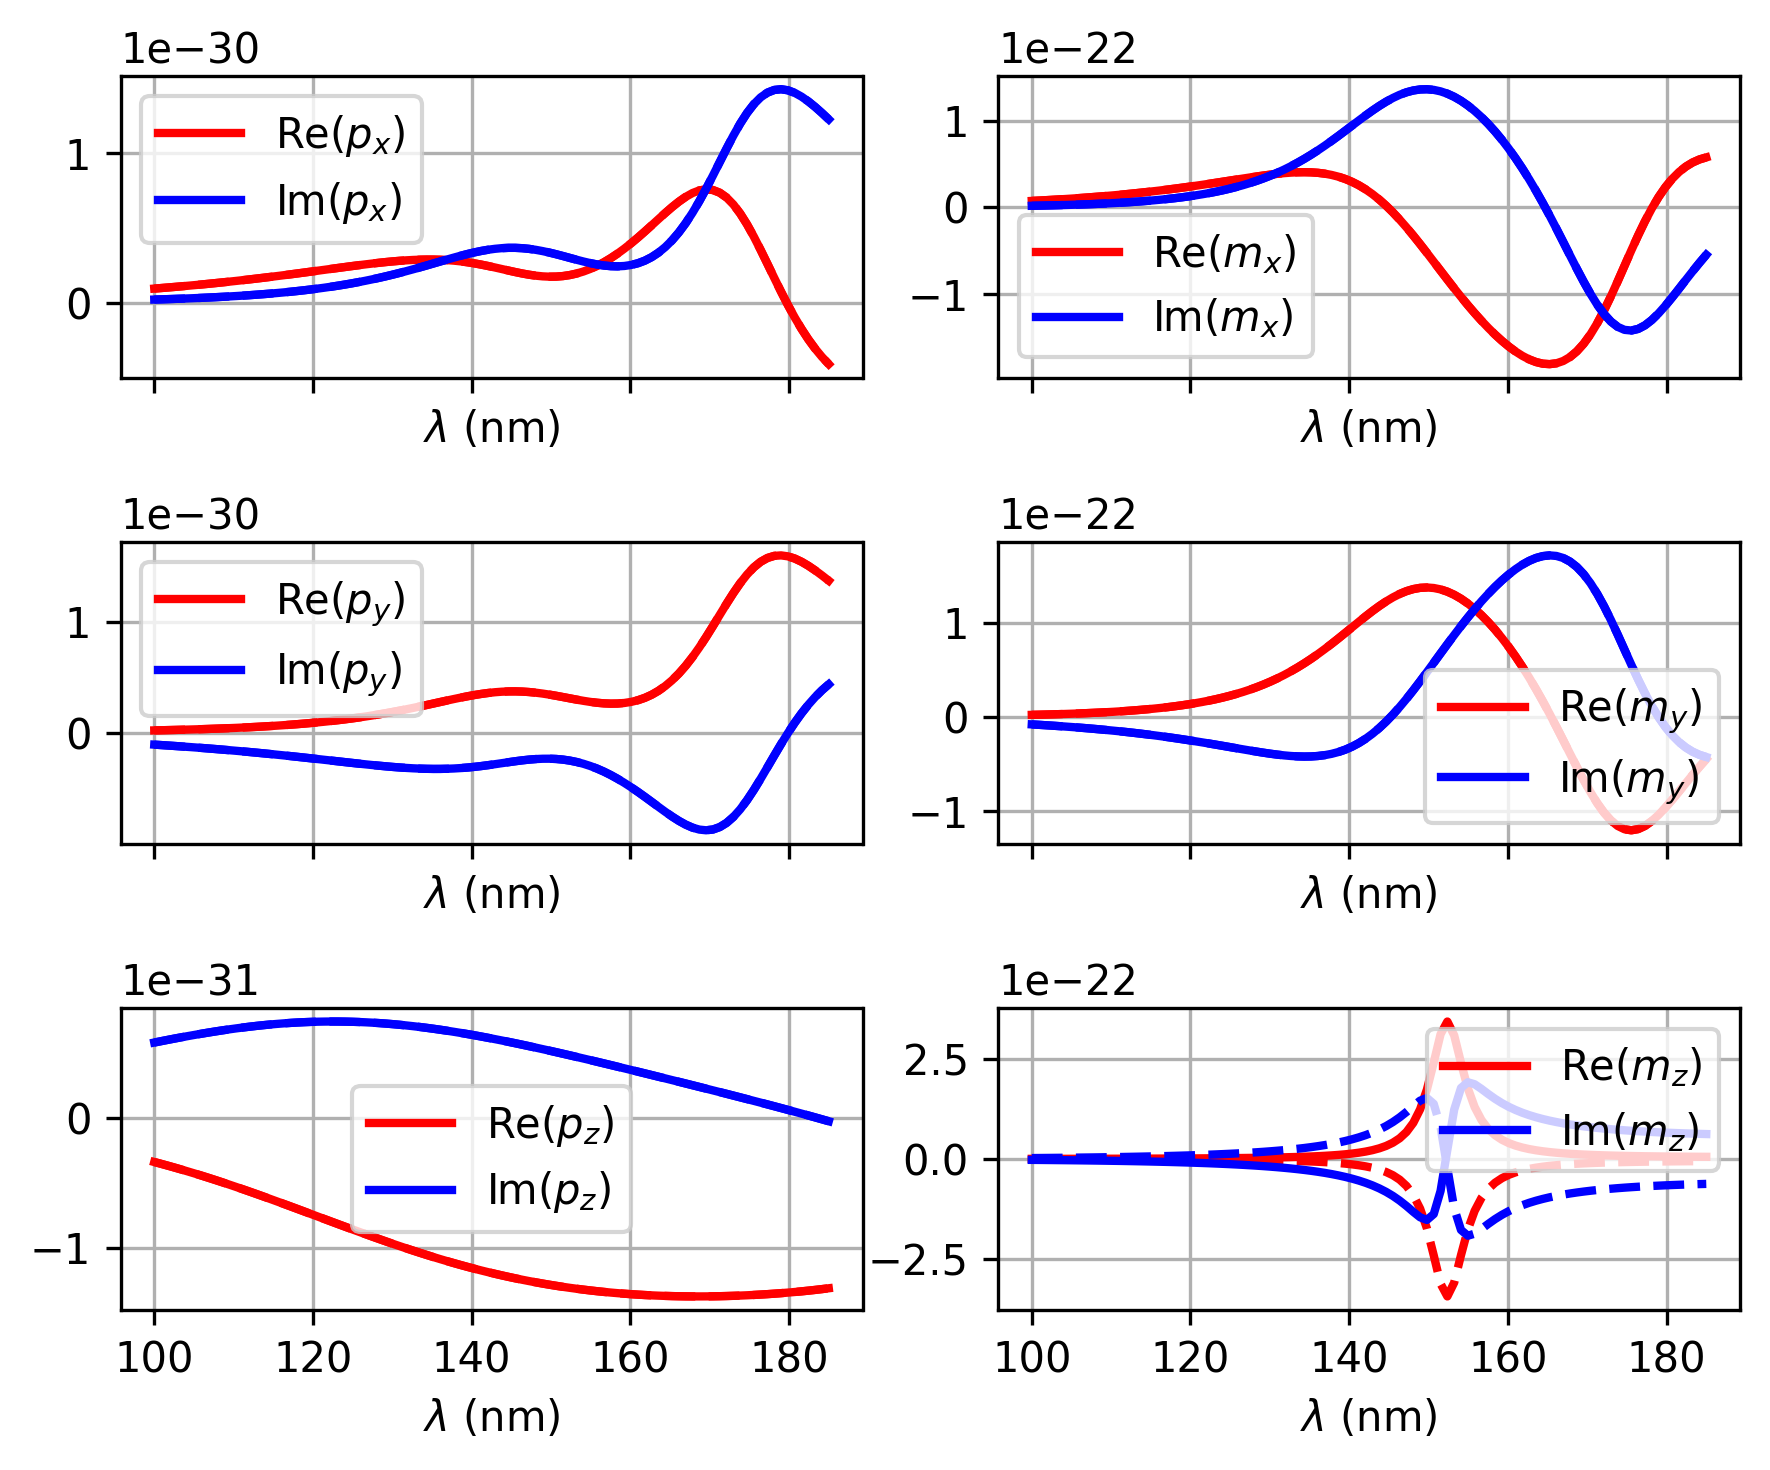

In [5]:
import numpy as np
import matplotlib.pyplot as plt


# --- 2. Угол силы ---
px_one = one_sweep_res["px"].apply(lambda x: x.magnitude).to_numpy()
py_one = one_sweep_res["py"].apply(lambda x: x.magnitude).to_numpy()
pz_one = one_sweep_res["pz"].apply(lambda x: x.magnitude).to_numpy()
mx_one = one_sweep_res["mx"].apply(lambda x: x.magnitude).to_numpy()
my_one = one_sweep_res["my"].apply(lambda x: x.magnitude).to_numpy()
mz_one = one_sweep_res["mz"].apply(lambda x: x.magnitude).to_numpy()

# --- 2. Угол силы ---
px_two = two_sweep_res["px"].apply(lambda x: x.magnitude).to_numpy()
py_two = two_sweep_res["py"].apply(lambda x: x.magnitude).to_numpy()
pz_two = two_sweep_res["pz"].apply(lambda x: x.magnitude).to_numpy()
mx_two = two_sweep_res["mx"].apply(lambda x: x.magnitude).to_numpy()
my_two = two_sweep_res["my"].apply(lambda x: x.magnitude).to_numpy()
mz_two = two_sweep_res["mz"].apply(lambda x: x.magnitude).to_numpy()

dips_one=[[px_one,py_one,pz_one],[mx_one,my_one,mz_one]]

dips_two = [[px_two,py_two,pz_two],[mx_two,my_two,mz_two]]

labels=[['$p_x$','$p_y$','$p_z$'],['$m_x$','$m_y$','$m_z$']]

R = one_sweep_res["R"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

# --- графики ---
fig, axs = plt.subplots(3, 2, figsize=(6, 5),dpi=300, sharex=True)

for i in range(2):
    for j in range(3):
        axs[j,i].plot(R, dips_one[i][j].real, label='Re('+labels[i][j]+')', lw=2, c='r')
        axs[j,i].plot(R, dips_two[i][j].real, lw=2, c='r', ls='--')
        axs[j,i].plot(R, dips_one[i][j].imag, label='Im('+labels[i][j]+')', lw=2, c='b')
        axs[j,i].plot(R, dips_two[i][j].imag, lw=2, c='b', ls='--')
        axs[j,i].legend()
        axs[j,i].grid()
        axs[j,i].set_xlabel('$\\lambda$ (nm)')

# axs[0].legend()
# axs[0].grid(True)

# # Y-компонента
# #axs[1].plot(wl, Fy_norm, label="$F_y / F_0^{max}$", lw=3)
# axs[1].plot(wl, Fy01, label="$F_{y,\\;sc}/ F_0^{max}$", lw=3)

# # axs[1].set_ylabel("$F_y^{spp}$ / $F_0^{max}$")
# axs[1].set_xlabel("$R$ (nm)")
# axs[1].legend()
# axs[1].grid(True)

# plt.suptitle("Force Components")
plt.tight_layout()
#plt.savefig('plots/Force_01_and_Cross.png', dpi=300)
plt.show()

In [7]:
#Free Space

base_config_free_space = SimulationConfig(
    wl = 900 * ureg.nanometer,
    R =  (295/2) * ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(0),
    a_angle = 0,
    phase= 0,
    substrate='Air'
)

sweep_res_free_space, _, _ = SweepRunner(base_config_free_space, 'R', np.linspace(100, 185, 100)*ureg.nanometer, True, False, True, False).run()



  0%|          | 0/100 [00:00<?, ?it/s]

In [74]:
import numpy as np
import matplotlib.pyplot as plt

F0 = np.max(np.abs(sweep_res_free_space['Fz'].to_numpy()))

Fx_one = one_sweep_res["Fx"].to_numpy()
Fy_one = one_sweep_res["Fy"].to_numpy()
R = one_sweep_res["R"].to_numpy()
Fxe0_one = one_sweep_res["Fxe0"].to_numpy()
Fxm0_one = one_sweep_res["Fxm0"].to_numpy()

Fxe1_one = one_sweep_res["Fxe1"].to_numpy()
Fxm1_one = one_sweep_res["Fxm1"].to_numpy()

Fye1_one = one_sweep_res["Fye1"].to_numpy()
Fym1_one = one_sweep_res["Fym1"].to_numpy()

Fxe2_one = one_sweep_res["Fxe2"].to_numpy()
Fxm2_one = one_sweep_res["Fxm2"].to_numpy()

Fye2_one = one_sweep_res["Fye2"].to_numpy()
Fym2_one = one_sweep_res["Fym2"].to_numpy()

Fxcross_one = one_sweep_res["Fxcross"].to_numpy()
Fycross_one = one_sweep_res["Fycross"].to_numpy()
Fxspp_one = one_sweep_res["Fxspp"].to_numpy()
Fyspp_one = one_sweep_res["Fyspp"].to_numpy()

Fx_nosc_one = Fx_one - Fxe0_one - Fxm0_one


Fx_nosc_noncross_one = Fx_nosc_one - Fxcross_one
Fy_nosc_noncross_one = Fy_one - Fycross_one

Fy01_one = Fy_one - Fycross_one - Fyspp_one 
Fx01_one = Fx_one - Fxcross_one - Fxspp_one - Fxe0_one - Fxm0_one



In [75]:
Fx_two = two_sweep_res["Fx"].to_numpy()
Fy_two = two_sweep_res["Fy"].to_numpy()
Fxe0_two = two_sweep_res["Fxe0"].to_numpy()
Fxm0_two = two_sweep_res["Fxm0"].to_numpy()
Fxe1_two = two_sweep_res["Fxe1"].to_numpy()
Fxm1_two = two_sweep_res["Fxm1"].to_numpy()

Fye1_two = two_sweep_res["Fye1"].to_numpy()
Fym1_two = two_sweep_res["Fym1"].to_numpy()

Fxe2_two = two_sweep_res["Fxe2"].to_numpy()
Fxm2_two = two_sweep_res["Fxm2"].to_numpy()

Fye2_two = two_sweep_res["Fye2"].to_numpy()
Fym2_two = two_sweep_res["Fym2"].to_numpy()

Fxcross_two = two_sweep_res["Fxcross"].to_numpy()
Fycross_two = two_sweep_res["Fycross"].to_numpy()
Fxspp_two = two_sweep_res["Fxspp"].to_numpy()
Fyspp_two = two_sweep_res["Fyspp"].to_numpy()

Fx_nosc_two = Fx_two - Fxe0_two - Fxm0_two

Fx_nosc_noncross_two = Fx_nosc_two - Fxcross_two
Fy_nosc_noncross_two = Fy_two - Fycross_two

Fy01_two = Fy_two - Fycross_two - Fyspp_two 
Fx01_two = Fx_two - Fxcross_two - Fxspp_two - Fxe0_two - Fxm0_two


In [126]:
def make_plot(loc):
    plt.grid()
    plt.xlabel('R (nm)')
    plt.legend(loc=loc)
    plt.show()

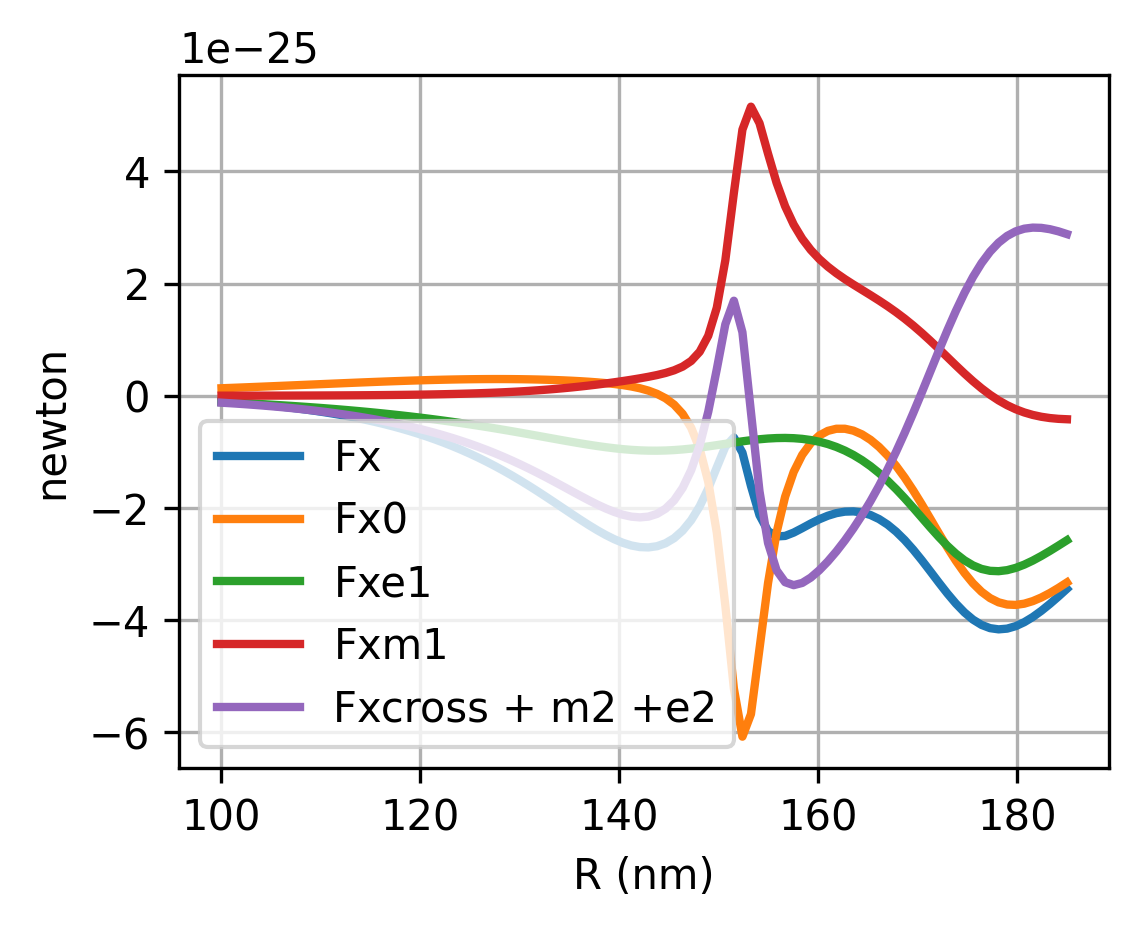

In [169]:
plt.figure(figsize=(4,3), dpi=300)

plt.plot(R, Fx_two, label='Fx', lw=2)
# plt.plot(R, Fxe0_two, label='Fxe0', lw=2)
plt.plot(R, Fxm0_two+Fxe0_two, label='Fx0', lw=2)

plt.plot(R, Fxe1_two, label='Fxe1', lw=2)
plt.plot(R, Fxm1_two, label='Fxm1', lw=2)

# plt.plot(R, Fxe2_two, label='Fxe2', lw=2)
# plt.plot(R, Fxm2_two, label='Fxm2', lw=2)

plt.plot(R, Fxcross_two+Fxe2_two+Fxm2_two, label='Fxcross + m2 +e2', lw=2)

make_plot('lower left')

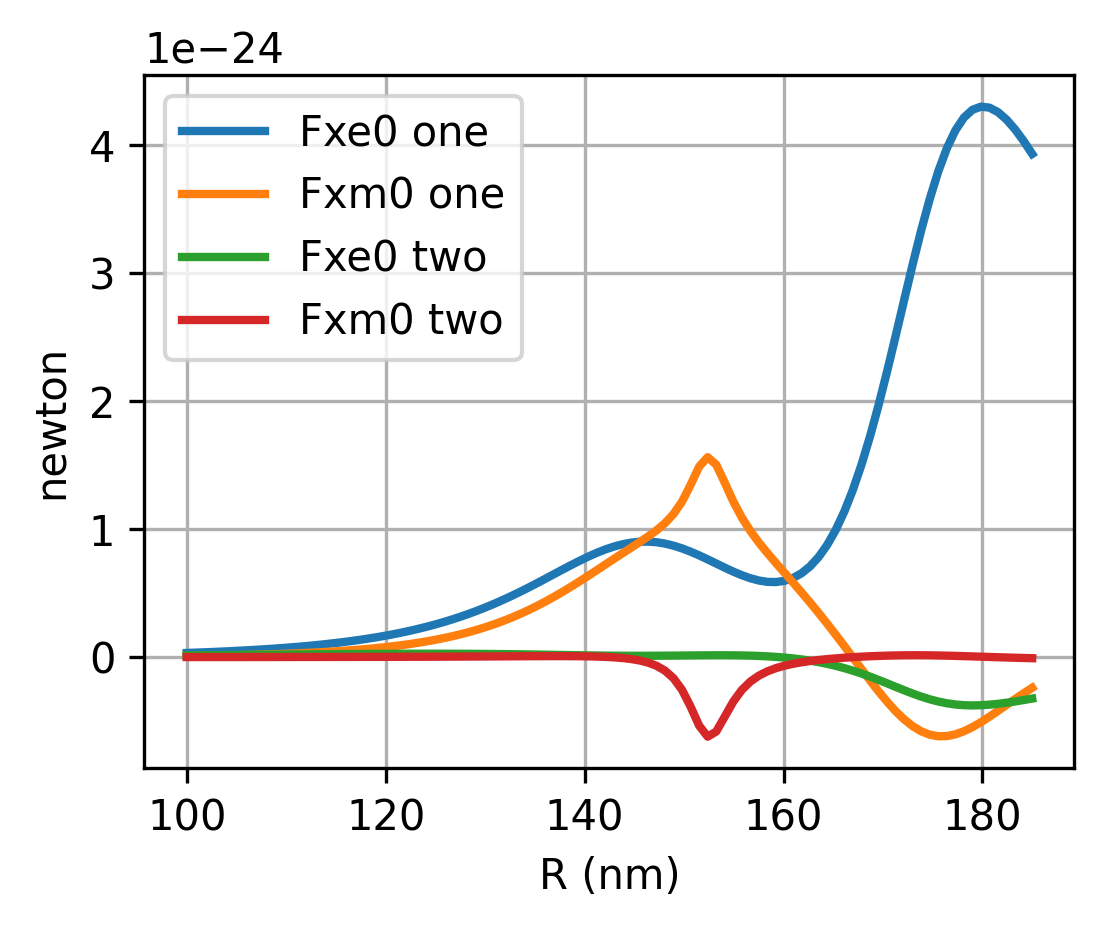

In [121]:
plt.figure(figsize=(4,3), dpi=300)

plt.plot(R, Fxe0_one, label='Fxe0 one', lw=2)
plt.plot(R, Fxm0_one, label='Fxm0 one', lw=2)

plt.plot(R, Fxe0_two, label='Fxe0 two', lw=2)
plt.plot(R, Fxm0_two, label='Fxm0 two', lw=2)

make_plot()

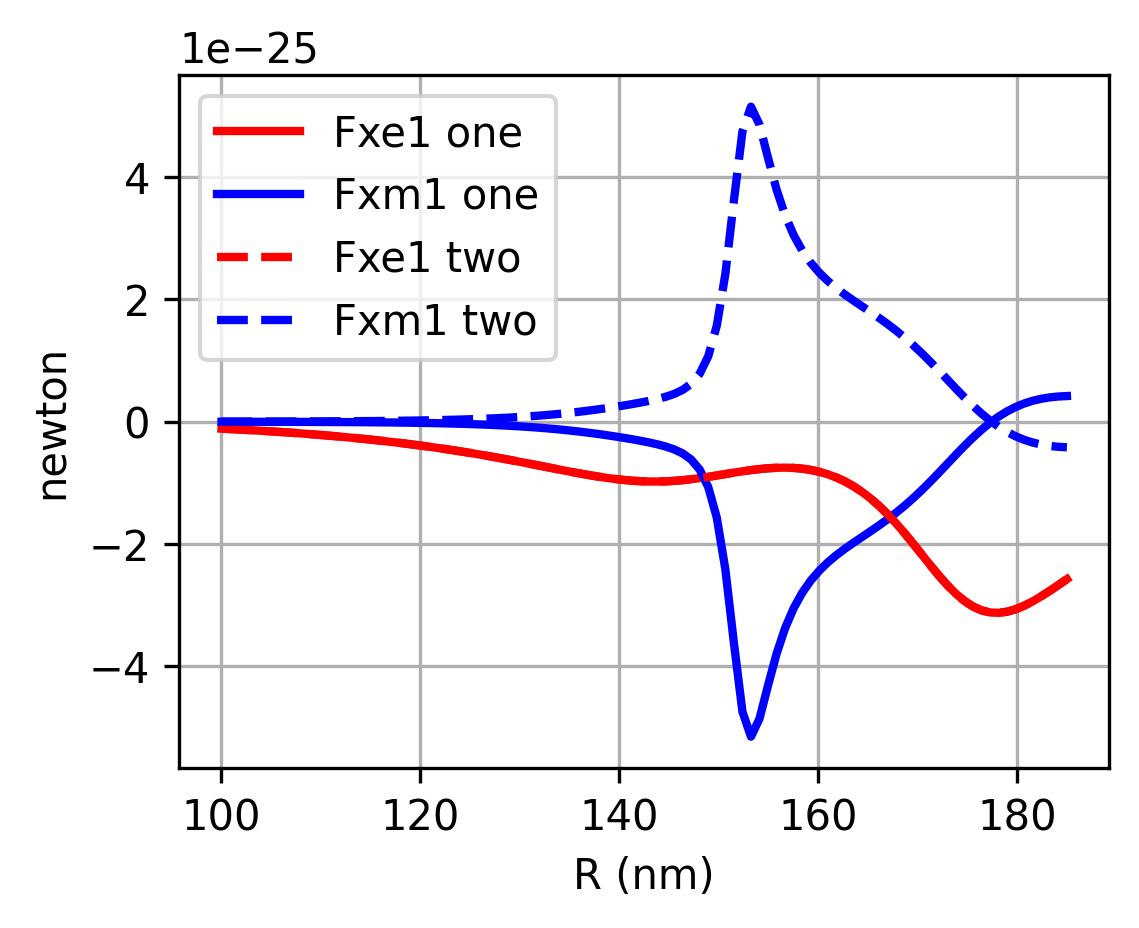

In [122]:
plt.figure(figsize=(4,3), dpi=300)

plt.plot(R, Fxe1_one, label='Fxe1 one', c='r', lw=2)
plt.plot(R, Fxm1_one, label='Fxm1 one', c='b',lw=2)

plt.plot(R, Fxe1_two, label='Fxe1 two', c='r', ls='--', lw=2)
plt.plot(R, Fxm1_two, label='Fxm1 two', c='b', ls='--', lw=2)


make_plot()

$$

F_x^{p_y^* m_z + \times} =  - \omega \mu_0 \left( Im( \partial_x[\nabla \times \hat{G}^H_{yz} ]) + \frac{k^3}{12 \pi} \right) Re(p_y^* m_z) 

$$



$$
F_x^{p_z^* m_y + \times} = - \omega \mu_0 \left( Im( \partial_x [\nabla \times \hat{G}^H_{zy}]) - \frac{k^3}{12 \pi} \right) Re(p_z^* m_y)
$$

In [152]:
from MieSppForce.green_func import dx_rot_green_E_H

dxrotGH = np.zeros((len(R),3,3), dtype=complex)
for i in range(len(R)):
    dxrotGH[i,:,:] = dx_rot_green_E_H(wl=one_beam_base_config.wl.to(ureg.nanometer).magnitude, 
                                      z0=one_beam_base_config.dist.to(ureg.nanometer).magnitude+
                                        + R[i].to(ureg.nanometer).magnitude, 
                                      eps_interp=one_beam_base_config.eps_substrate,
                                      stop=45)[1]


In [129]:
c_const = 299792458
k = 2 * np.pi / one_beam_base_config.wl.to(ureg.meter).magnitude
omega = c_const * k
mu0 = 4 * np.pi * 1e-7
eps0_const = 1/(4*np.pi*c_const**2)*1e7 

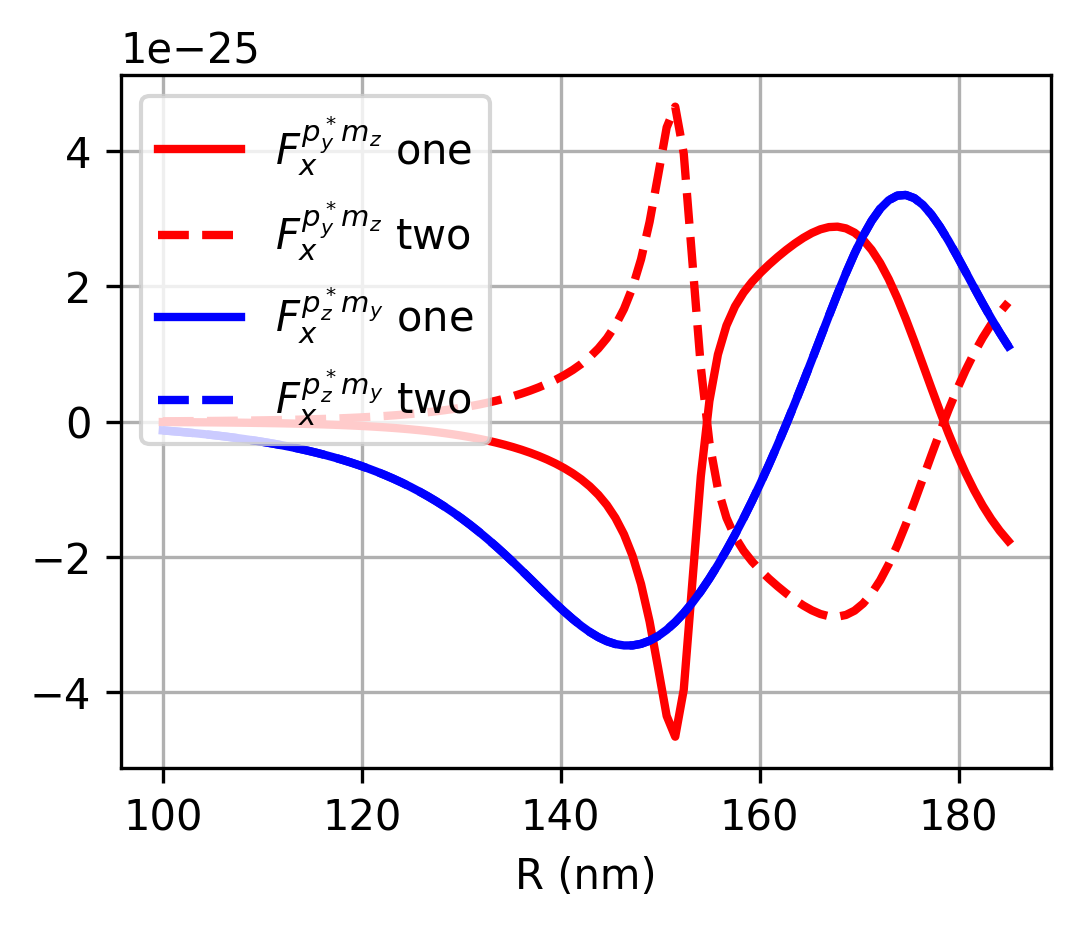

In [144]:
plt.figure(figsize=(4,3), dpi=300)

plt.plot(R, -omega*mu0* (np.imag(dxrotGH[:,1,2])+k**3/(12*np.pi))*np.real(py_one.conj()*mz_one), label='$F_x^{p_y^* m_z}$ one', c='r', lw=2)

plt.plot(R, -omega*mu0* (np.imag(dxrotGH[:,1,2])+ k**3/(12*np.pi))*np.real(py_two.conj()*mz_two), label='$F_x^{p_y^* m_z}$ two', c='r', ls='--', lw=2)

plt.plot(R, -omega*mu0* (np.imag(dxrotGH[:,2,1])- k**3/(12*np.pi))*np.real(pz_one.conj()*my_one), label='$F_x^{p_z^* m_y}$ one', c='b', lw=2)
plt.plot(R, -omega*mu0* (np.imag(dxrotGH[:,2,1])- k**3/(12*np.pi))*np.real(pz_two.conj()*my_two), label='$F_x^{p_z^* m_y}$ two', c='b', ls='--', lw=2)


make_plot(loc='upper left')


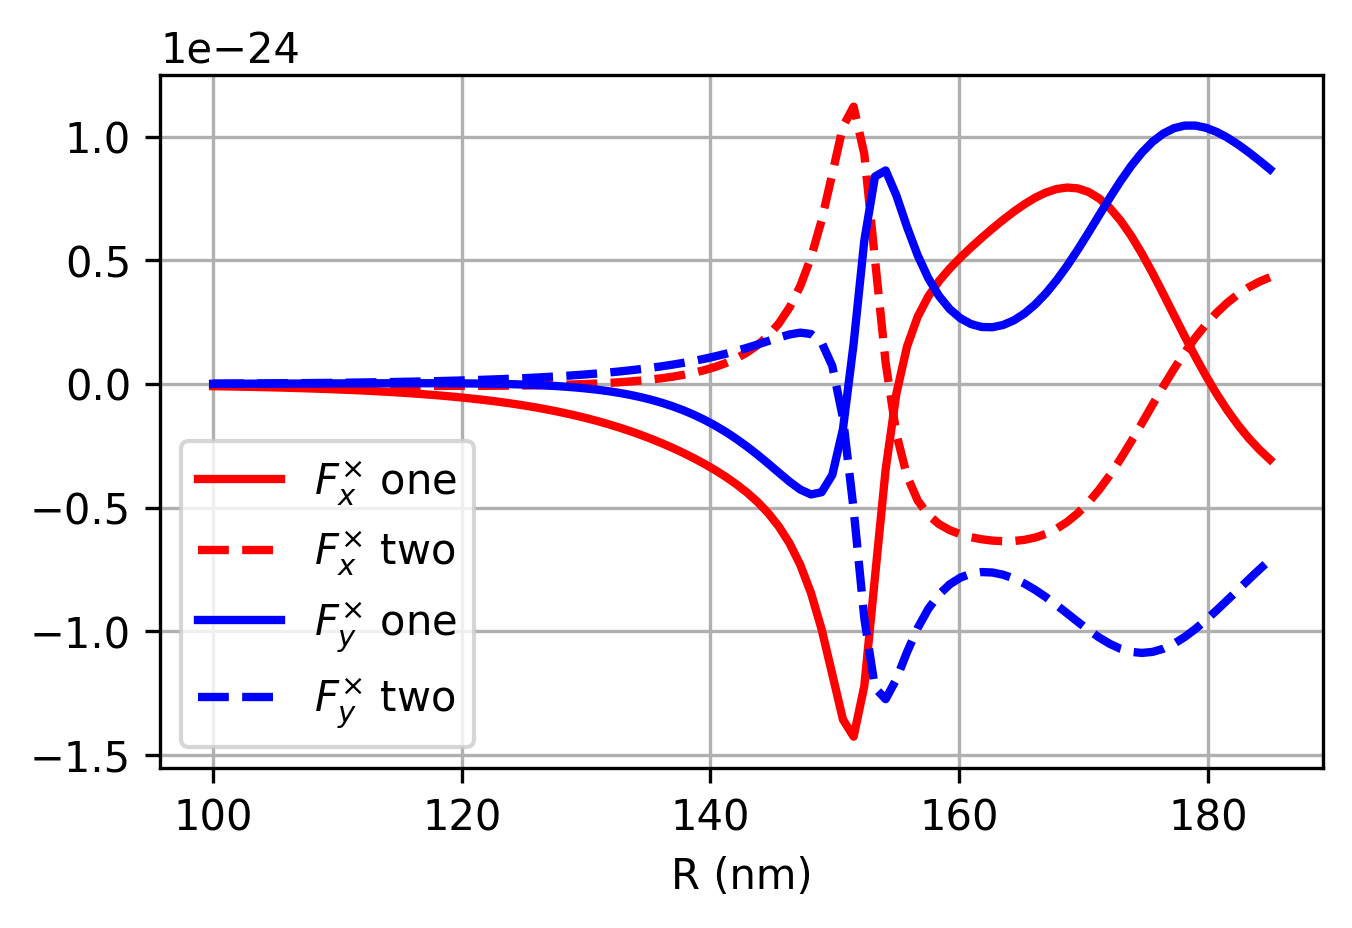

In [156]:
plt.figure(figsize=(5,3), dpi=300)
plt.plot(R, -k**4/(12*np.pi*c_const*eps0_const) * np.real( py_one*mz_one.conj() - pz_one*my_one.conj()), label='$F_x^{\\times}$ one', c='r', lw=2)
plt.plot(R, -k**4/(12*np.pi*c_const*eps0_const) * np.real( py_two*mz_two.conj() - pz_two*my_two.conj()), label='$F_x^{\\times}$ two', c='r',ls='--', lw=2)


plt.plot(R, -k**4/(12*np.pi*c_const*eps0_const) * np.real( pz_one*mx_one.conj() - px_one*mz_one.conj()), label='$F_y^{\\times}$ one', c='b', lw=2)
plt.plot(R, -k**4/(12*np.pi*c_const*eps0_const) * np.real( pz_two*mx_two.conj() - px_two*mz_two.conj()), label='$F_y^{\\times}$ two', c='b',ls='--', lw=2)


make_plot('best')

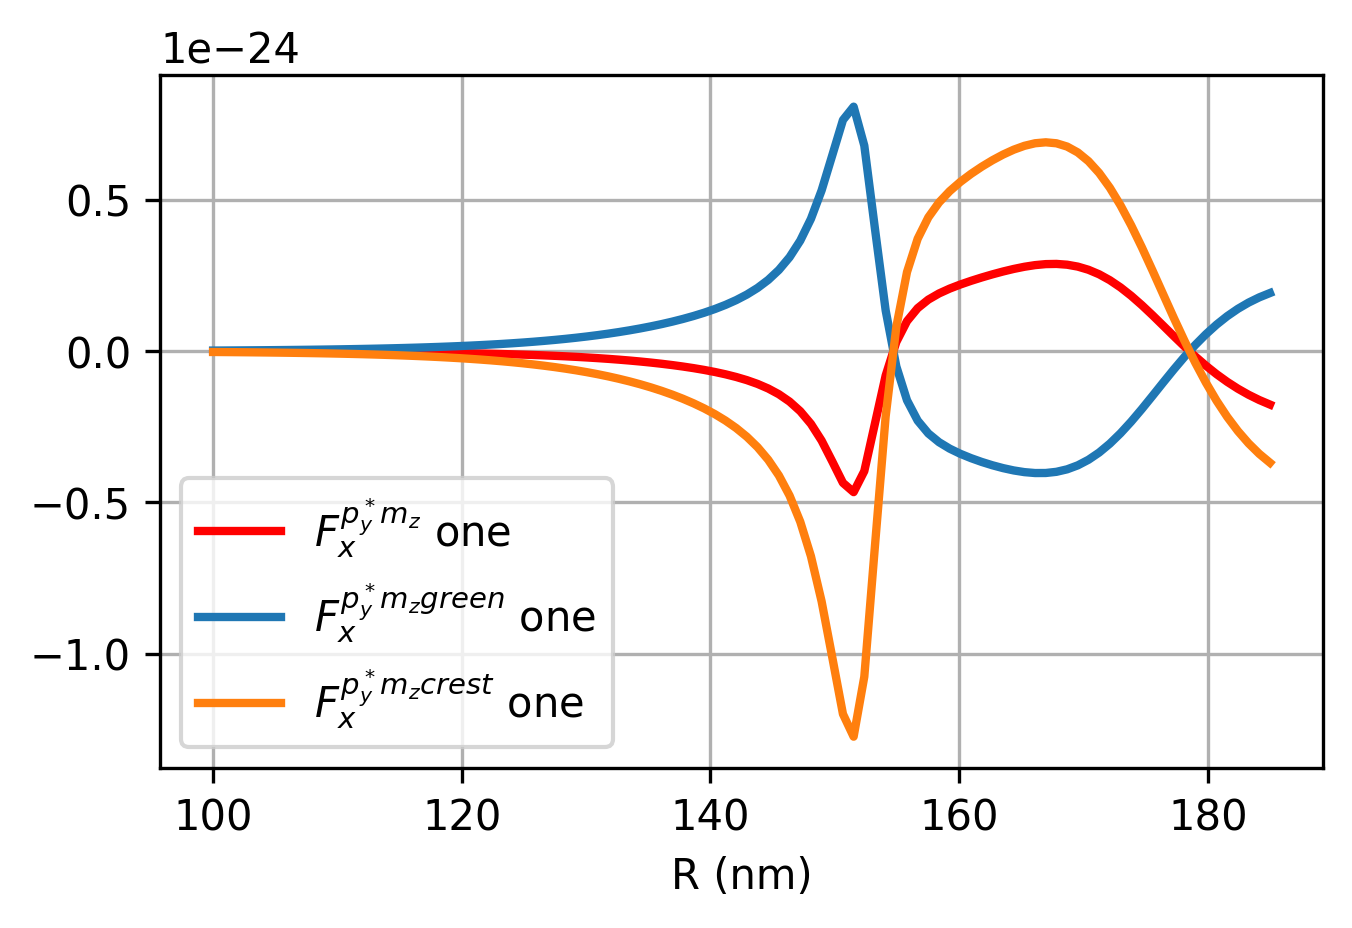

In [133]:
plt.figure(figsize=(5,3), dpi=300)
plt.plot(R, -omega*mu0* (np.imag(dxrotGH[:,1,2,])+k**3/(12*np.pi))*np.real(py_one.conj()*mz_one), label='$F_x^{p_y^* m_z}$ one', c='r', lw=2)
plt.plot(R, -omega*mu0* (np.imag(dxrotGH[:,1,2,]))*np.real(py_one.conj()*mz_one), label='$F_x^{p_y^* m_z green}$ one', lw=2 )
plt.plot(R, -omega*mu0* (k**3/(12*np.pi))*np.real(py_one.conj()*mz_one), label='$F_x^{p_y^* m_z crest}$ one', lw=2)


# plt.plot(R, -omega*mu0* (np.imag(dxrotGH[:,1,2,])+ k**3/(12*np.pi))*np.real(py_two.conj()*mz_two), label='$F_x^{p_y^* m_z}$ two', c='r', ls='--', lw=2)
make_plot(loc='best')

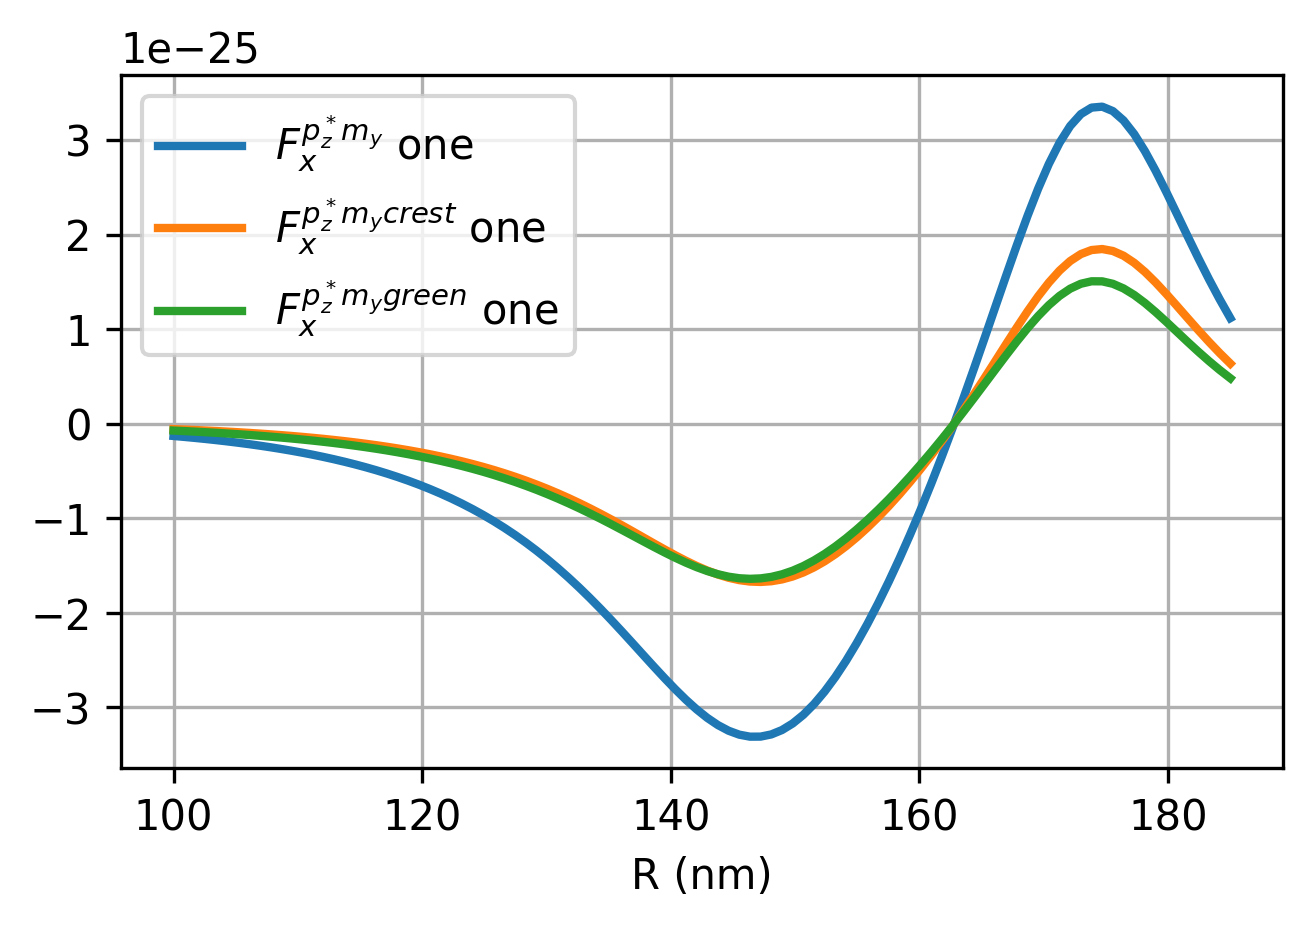

In [148]:
plt.figure(figsize=(5,3), dpi=300)
plt.plot(R, -omega*mu0* (np.imag(dxrotGH[:,2,1])- k**3/(12*np.pi))*np.real(pz_one.conj()*my_one), label='$F_x^{p_z^* m_y}$ one',  lw=2)
plt.plot(R, omega*mu0*  k**3/(12*np.pi)*np.real(pz_one.conj()*my_one), label='$F_x^{p_z^* m_y crest}$ one', lw=2)

plt.plot(R, -omega*mu0* np.imag(dxrotGH[:,2,1])*np.real(pz_one.conj()*my_one), label='$F_x^{p_z^* m_y green}$ one', lw=2)

make_plot(loc='best')

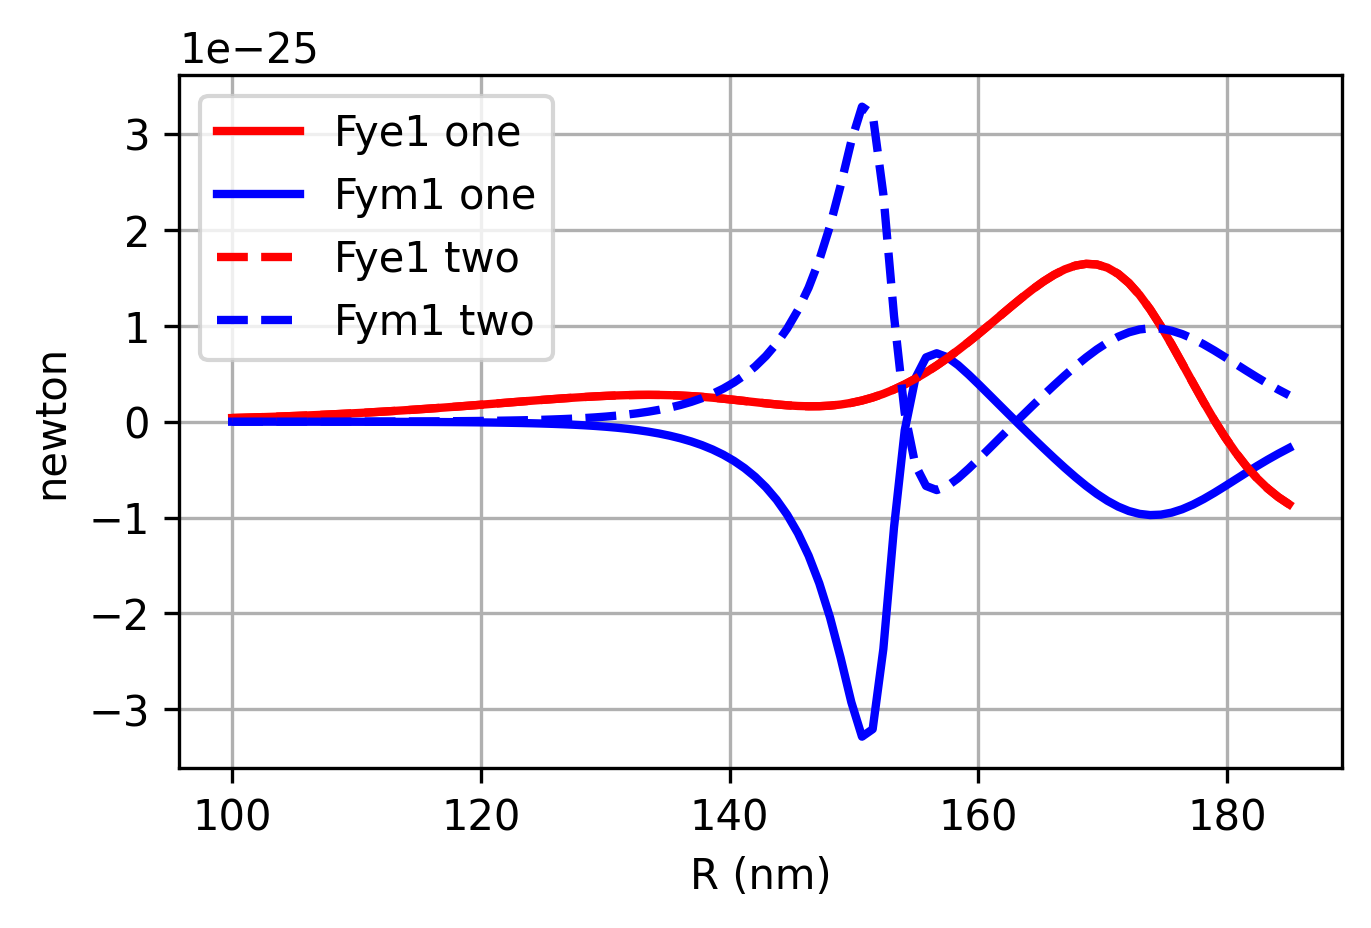

In [157]:
plt.figure(figsize=(5,3), dpi=300)
plt.plot(R, Fye1_one, label='Fye1 one', c='r', lw=2)
plt.plot(R, Fym1_one, label='Fym1 one', c='b',lw=2)

plt.plot(R, Fye1_two, label='Fye1 two', c='r', ls='--', lw=2)
plt.plot(R, Fym1_two, label='Fym1 two', c='b', ls='--', lw=2)


make_plot('best')

$$
F_y^{p_x^* m_z + \times} = -\omega \mu_0 \left( Im(\partial_y [\nabla \times \hat{G}^H_{xz} ]) - \frac{k^3}{12 \pi} \right) Re(p_x^* m_z) 

$$

$$
F_y^{p_z^* m_x + \times} = -\omega \mu_0 \left( Im( \partial_y  [\nabla \times \hat{G}^H_{zx}] )+ \frac{k^3}{12 \pi} \right) Re(p_z^* m_x)

$$

In [90]:
from MieSppForce.green_func import dy_rot_green_E_H

dyrotGH = np.zeros((len(R),3,3), dtype=complex)
for i in range(len(R)):
    dyrotGH[i,:,:] = dy_rot_green_E_H(wl=one_beam_base_config.wl.to(ureg.nanometer).magnitude, 
                                      z0=one_beam_base_config.dist.to(ureg.nanometer).magnitude+
                                        + R[i].to(ureg.nanometer).magnitude, 
                                      eps_interp=one_beam_base_config.eps_substrate,
                                      stop=45)[1]


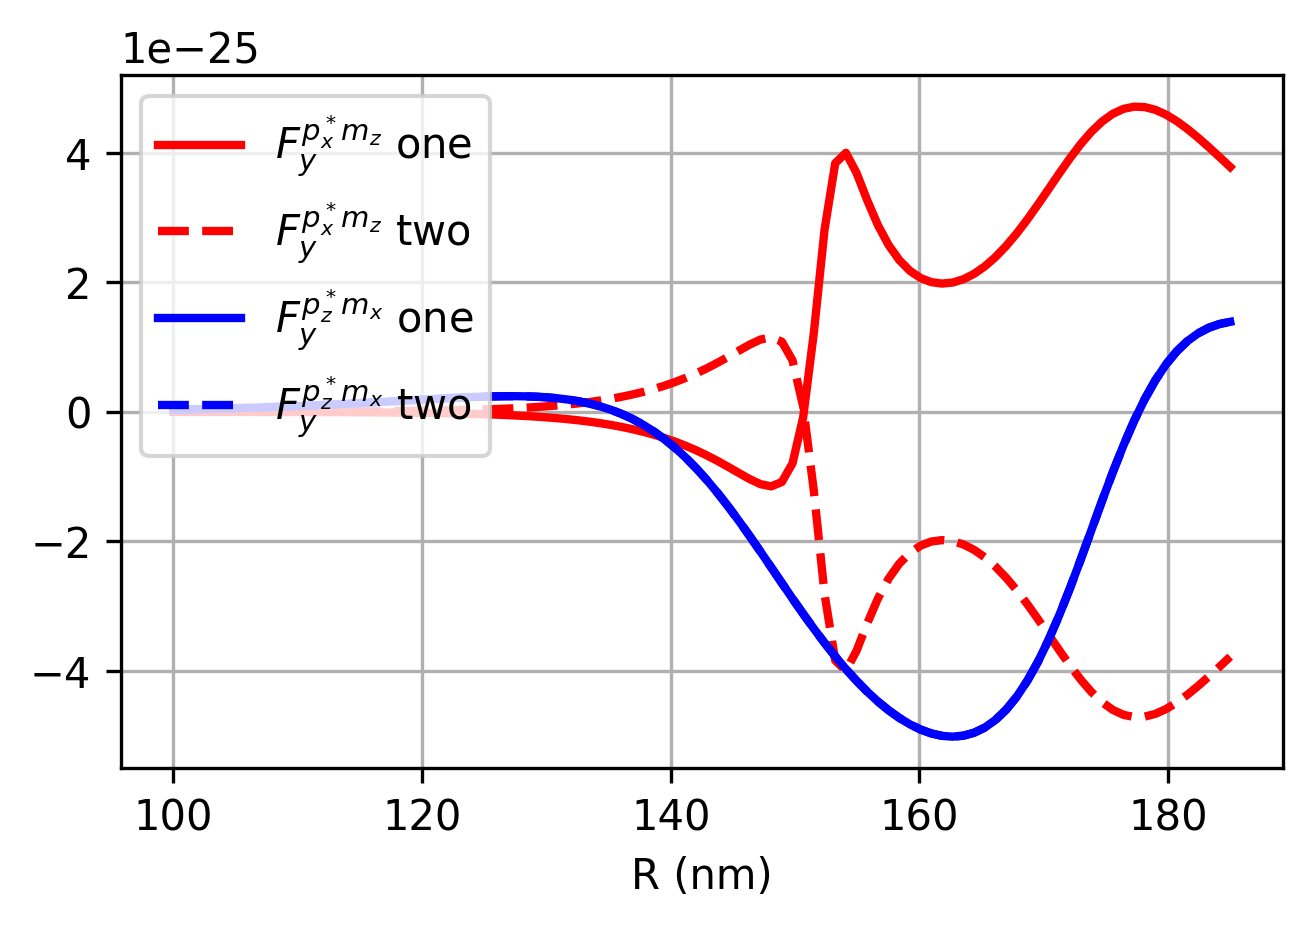

In [160]:
plt.figure(figsize=(5,3), dpi=300)

plt.plot(R, -omega*mu0* (np.imag(dyrotGH[:,0,2])-k**3/(12*np.pi))*np.real(px_one.conj()*mz_one), label='$F_y^{p_x^* m_z}$ one', c='r', lw=2)

plt.plot(R, -omega*mu0* (np.imag(dyrotGH[:,0,2])- k**3/(12*np.pi))*np.real(px_two.conj()*mz_two), label='$F_y^{p_x^* m_z}$ two', c='r', ls='--', lw=2)

plt.plot(R, -omega*mu0* (np.imag(dyrotGH[:,2,0])+ k**3/(12*np.pi))*np.real(pz_one.conj()*mx_one), label='$F_y^{p_z^* m_x}$ one', c='b', lw=2)
plt.plot(R, -omega*mu0* (np.imag(dyrotGH[:,2,0])+ k**3/(12*np.pi))*np.real(pz_two.conj()*mx_two), label='$F_y^{p_z^* m_x}$ two', c='b', ls='--', lw=2)


make_plot('upper left')

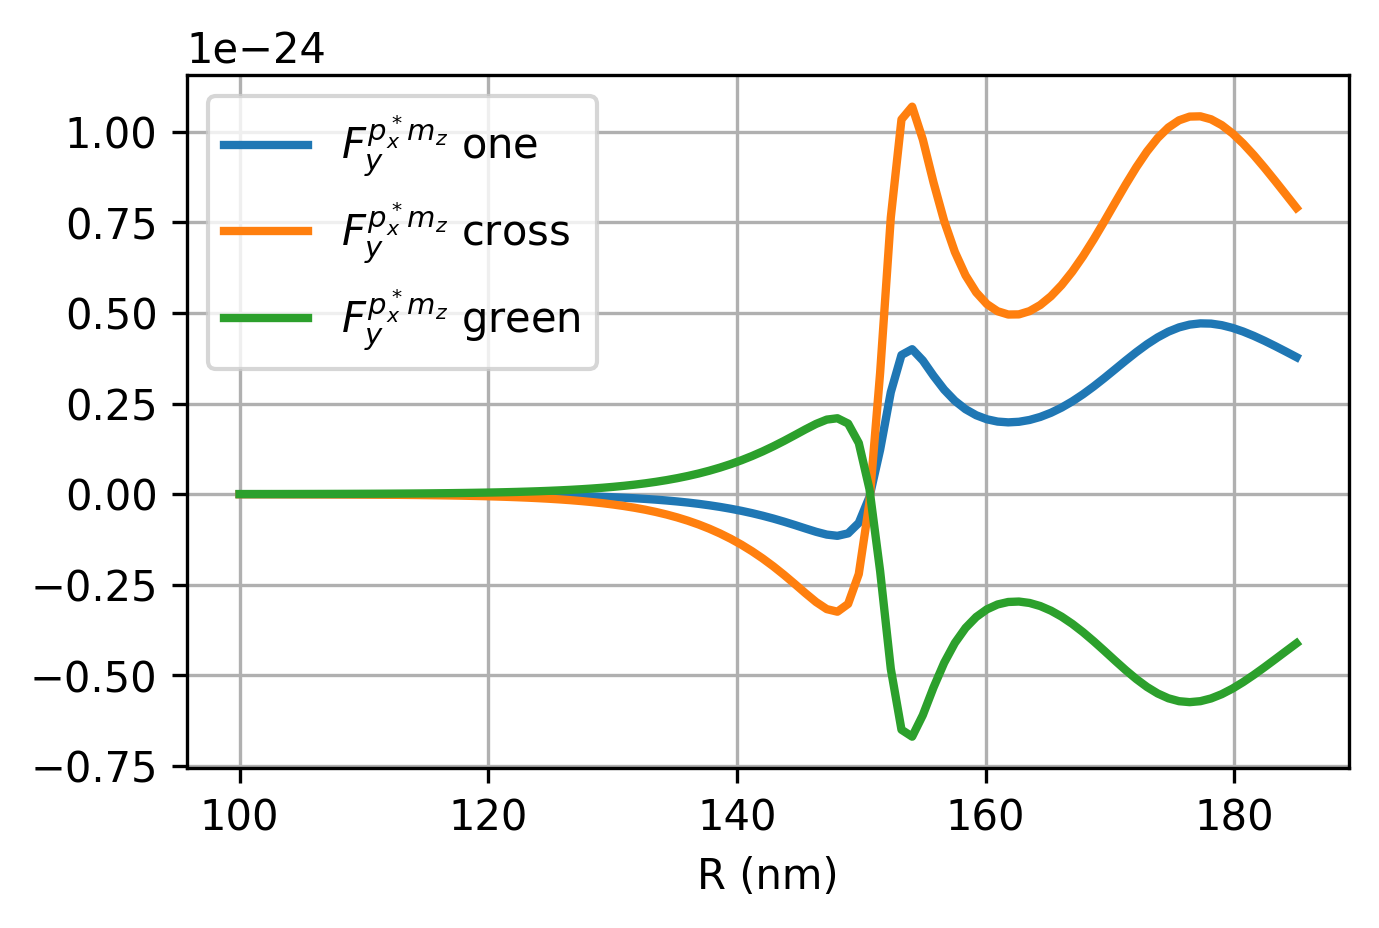

In [162]:
plt.figure(figsize=(5,3), dpi=300)

plt.plot(R, -omega*mu0* (np.imag(dyrotGH[:,0,2])-k**3/(12*np.pi))*np.real(px_one.conj()*mz_one), label='$F_y^{p_x^* m_z}$ one', lw=2)

plt.plot(R, -omega*mu0* (-k**3/(12*np.pi))*np.real(px_one.conj()*mz_one), label='$F_y^{p_x^* m_z}$ cross', lw=2)

plt.plot(R, -omega*mu0* (np.imag(dyrotGH[:,0,2]))*np.real(px_one.conj()*mz_one), label='$F_y^{p_x^* m_z}$ green', lw=2)

make_plot('best')

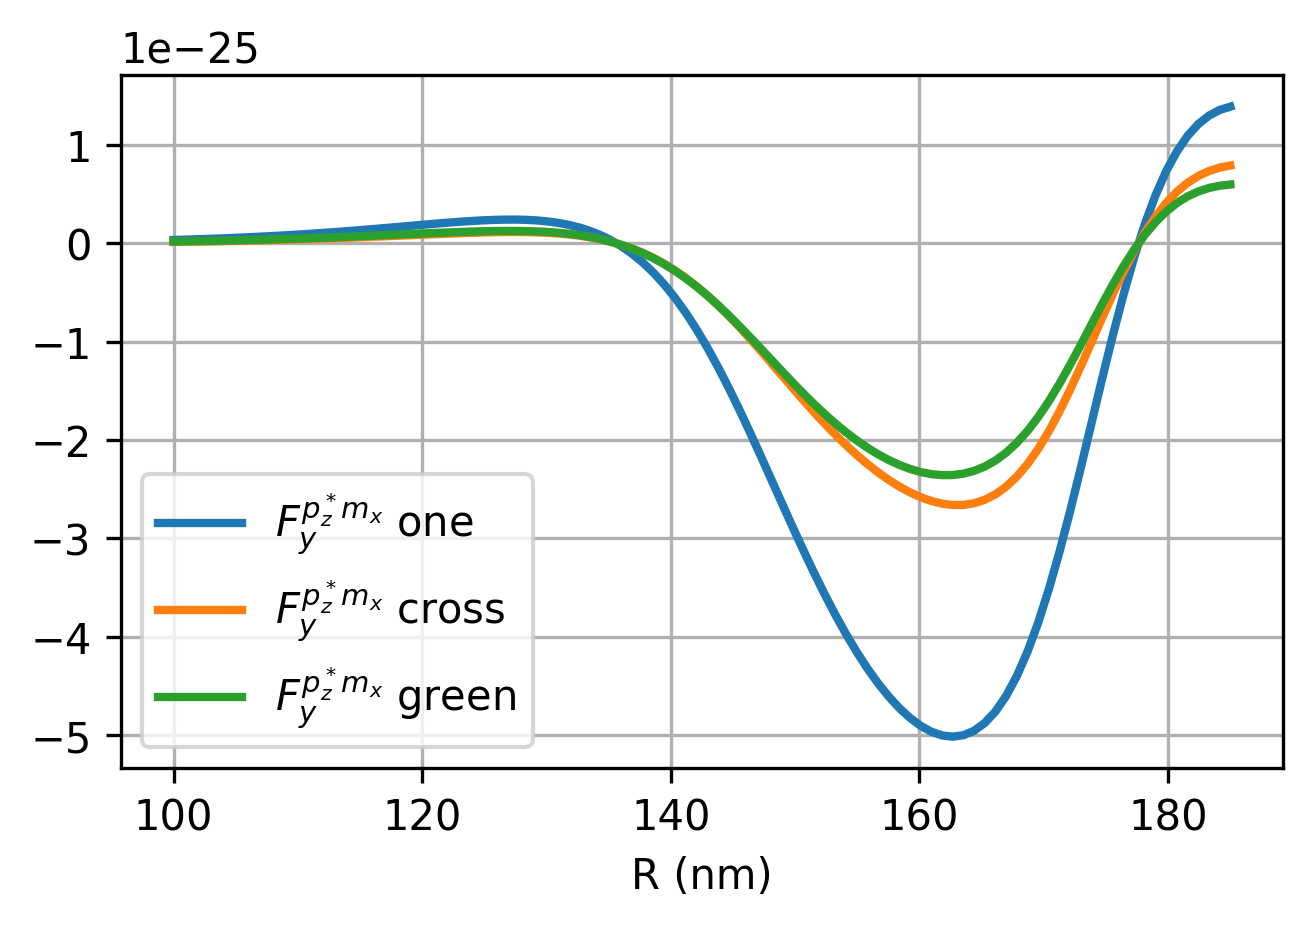

In [163]:
plt.figure(figsize=(5,3), dpi=300)

plt.plot(R, -omega*mu0* (np.imag(dyrotGH[:,2,0])+ k**3/(12*np.pi))*np.real(pz_one.conj()*mx_one), label='$F_y^{p_z^* m_x}$ one', lw=2)

plt.plot(R, -omega*mu0* ( k**3/(12*np.pi))*np.real(pz_one.conj()*mx_one), label='$F_y^{p_z^* m_x}$ cross', lw=2)

plt.plot(R, -omega*mu0* (np.imag(dyrotGH[:,2,0]))*np.real(pz_one.conj()*mx_one), label='$F_y^{p_z^* m_x}$ green', lw=2)

make_plot('best')

In [170]:
from MieSppForce.green_func import dx_rot_green_E_H

dxrotGH01 = np.zeros((len(R),3,3), dtype=complex)
for i in range(len(R)):
    dxrotGH01[i,:,:] = dx_rot_green_E_H(wl=one_beam_base_config.wl.to(ureg.nanometer).magnitude, 
                                      z0=one_beam_base_config.dist.to(ureg.nanometer).magnitude+
                                        + R[i].to(ureg.nanometer).magnitude, 
                                      eps_interp=one_beam_base_config.eps_substrate,
                                      stop=1)[1]
    
dyrotGH01 = np.zeros((len(R),3,3), dtype=complex)
for i in range(len(R)):
    dyrotGH01[i,:,:] = dy_rot_green_E_H(wl=one_beam_base_config.wl.to(ureg.nanometer).magnitude, 
                                      z0=one_beam_base_config.dist.to(ureg.nanometer).magnitude+
                                        + R[i].to(ureg.nanometer).magnitude, 
                                      eps_interp=one_beam_base_config.eps_substrate,
                                      stop=1)[1]
    

dxrotGHspp = dxrotGH - dxrotGH01
dyrotGHspp = dyrotGH - dyrotGH01

In [181]:
Fxe1_one = one_sweep_res["Fxe1"].apply(lambda x: x.magnitude).to_numpy()
Fye1_one = one_sweep_res["Fye1"].apply(lambda x: x.magnitude).to_numpy()
Fxm1_one = one_sweep_res["Fxm1"].apply(lambda x: x.magnitude).to_numpy()
Fym1_one = one_sweep_res["Fym1"].apply(lambda x: x.magnitude).to_numpy()

Fxe1_spp_one = one_sweep_res["Fxsppe1"].apply(lambda x: x.magnitude).to_numpy()
Fye1_spp_one = one_sweep_res["Fysppe1"].apply(lambda x: x.magnitude).to_numpy()

Fxe1_01_one = Fxe1_one - Fxe1_spp_one
Fye1_01_one = Fye1_one - Fye1_spp_one

Fxm1_spp_one = one_sweep_res["Fxsppm1"].apply(lambda x: x.magnitude).to_numpy()
Fym1_spp_one = one_sweep_res["Fysppm1"].apply(lambda x: x.magnitude).to_numpy()

Fxm1_01_one = Fxm1_one - Fxm1_spp_one
Fym1_01_one = Fym1_one - Fym1_spp_one

Fxpymz_one = -omega*mu0* (np.imag(dxrotGH[:,1,2])+k**3/(12*np.pi))*np.real(py_one.conj()*mz_one)
Fxpzmy_one = -omega*mu0* (np.imag(dxrotGH[:,2,1])- k**3/(12*np.pi))*np.real(pz_one.conj()*my_one)


Fxpymz_spp_one =  -omega*mu0* (np.imag(dxrotGHspp[:,1,2]))*np.real(py_one.conj()*mz_one)
Fxpzmy_spp_one = -omega*mu0* (np.imag(dxrotGHspp[:,2,1]))*np.real(pz_one.conj()*my_one)

Fxpymz_01_one = Fxpymz_one - Fxpymz_spp_one
Fxpzmy_01_one = Fxpzmy_one - Fxpzmy_spp_one

Fypxmz_one = -omega*mu0* (np.imag(dyrotGH[:,0,2])-k**3/(12*np.pi))*np.real(px_one.conj()*mz_one)
Fypzmx_one = -omega*mu0* (np.imag(dyrotGH[:,2,0])+ k**3/(12*np.pi))*np.real(pz_one.conj()*mx_one)

Fypxmz_spp_one =  -omega*mu0* (np.imag(dyrotGHspp[:,0,2]))*np.real(px_one.conj()*mz_one)
Fypzmx_spp_one = -omega*mu0* (np.imag(dyrotGHspp[:,2,0]))*np.real(pz_one.conj()*mx_one)

Fypxmz_01_one = Fypxmz_one - Fypxmz_spp_one
Fypzmx_01_one = Fypzmx_one - Fypzmx_spp_one

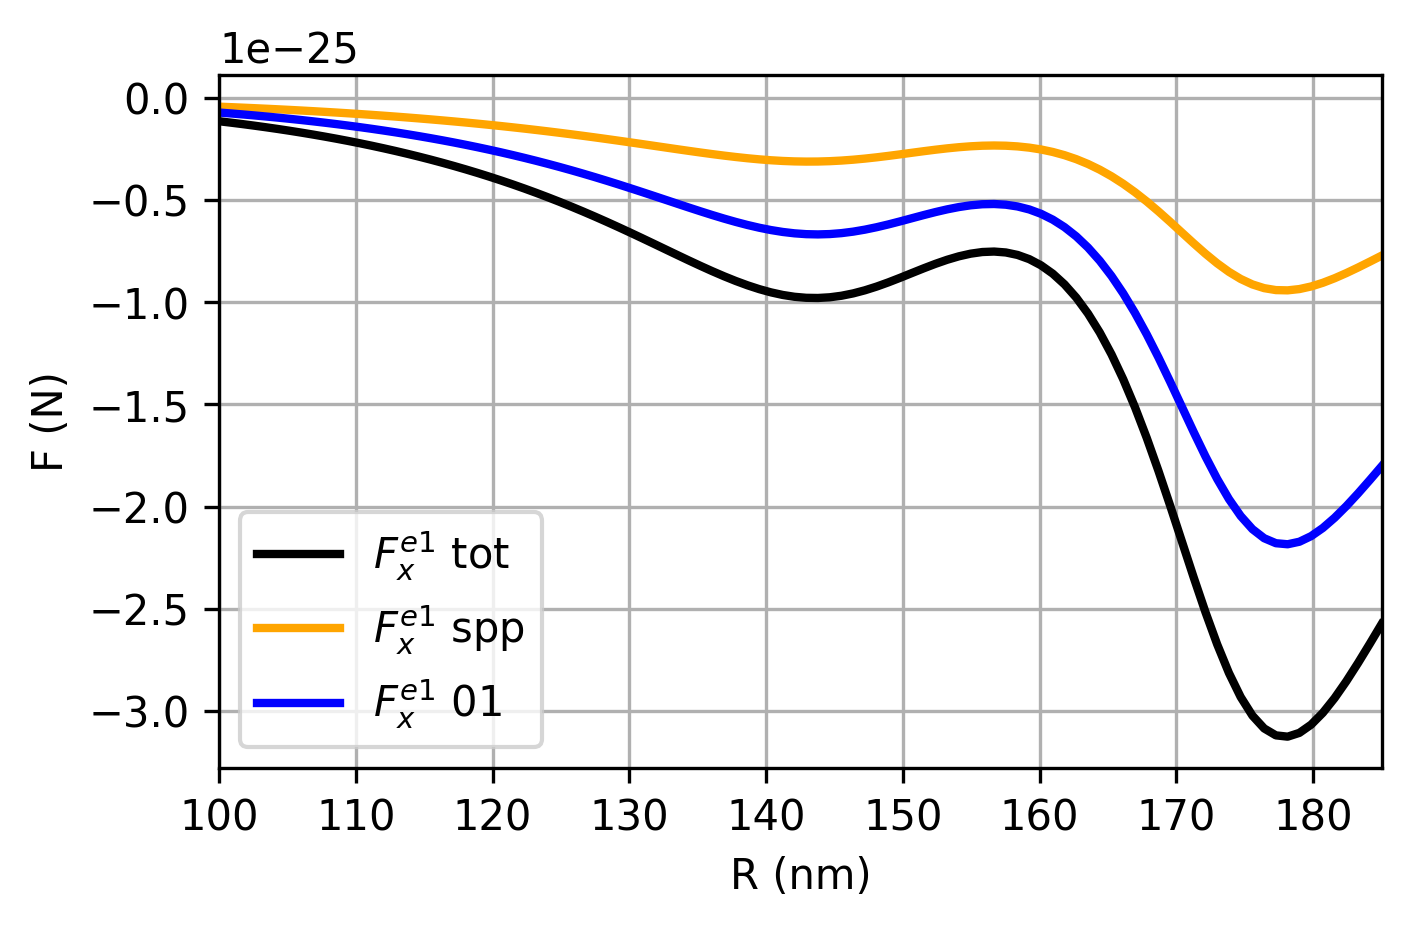

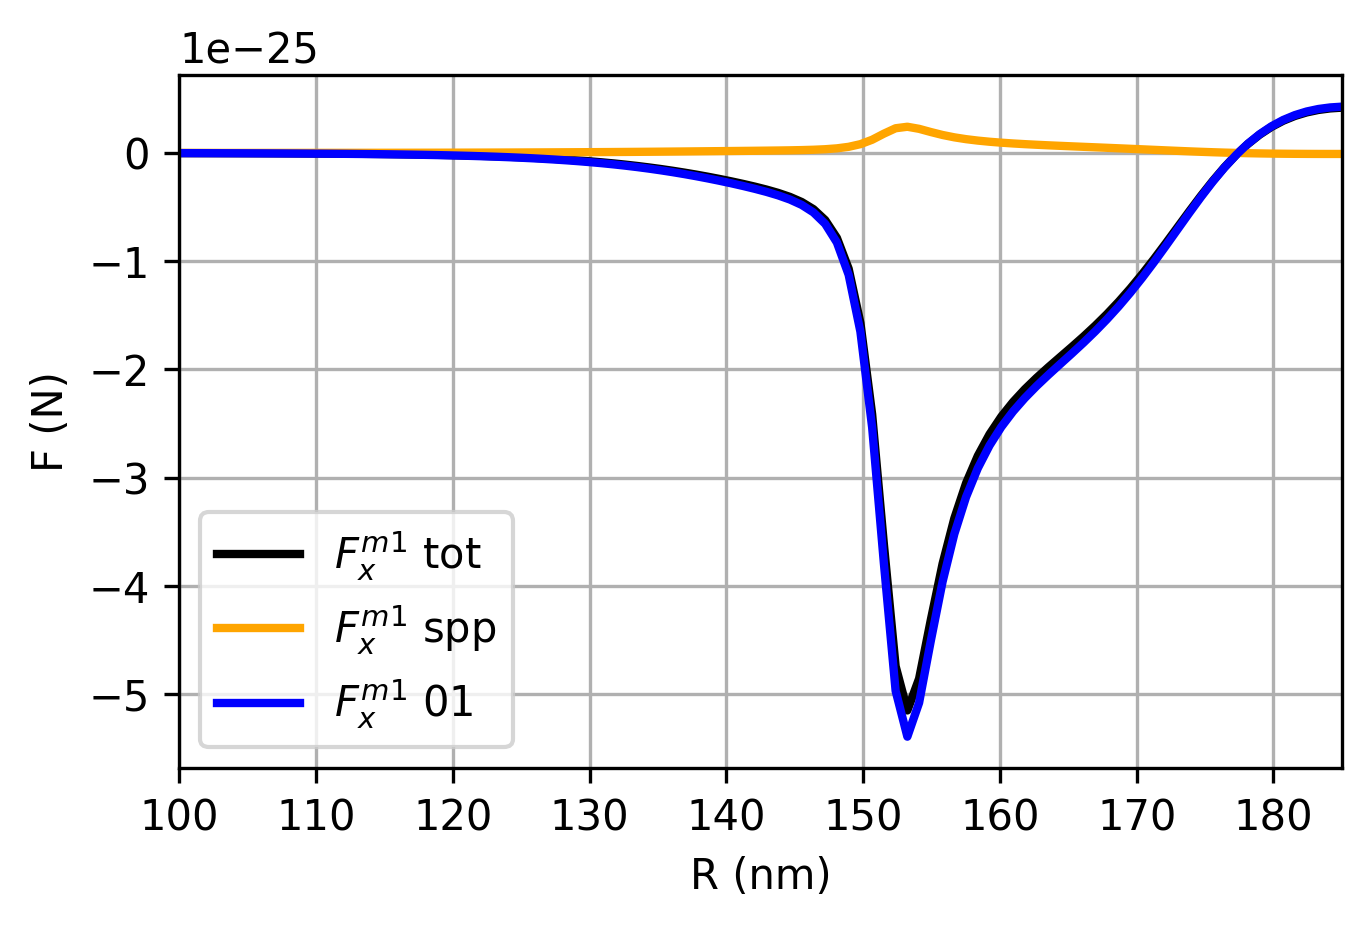

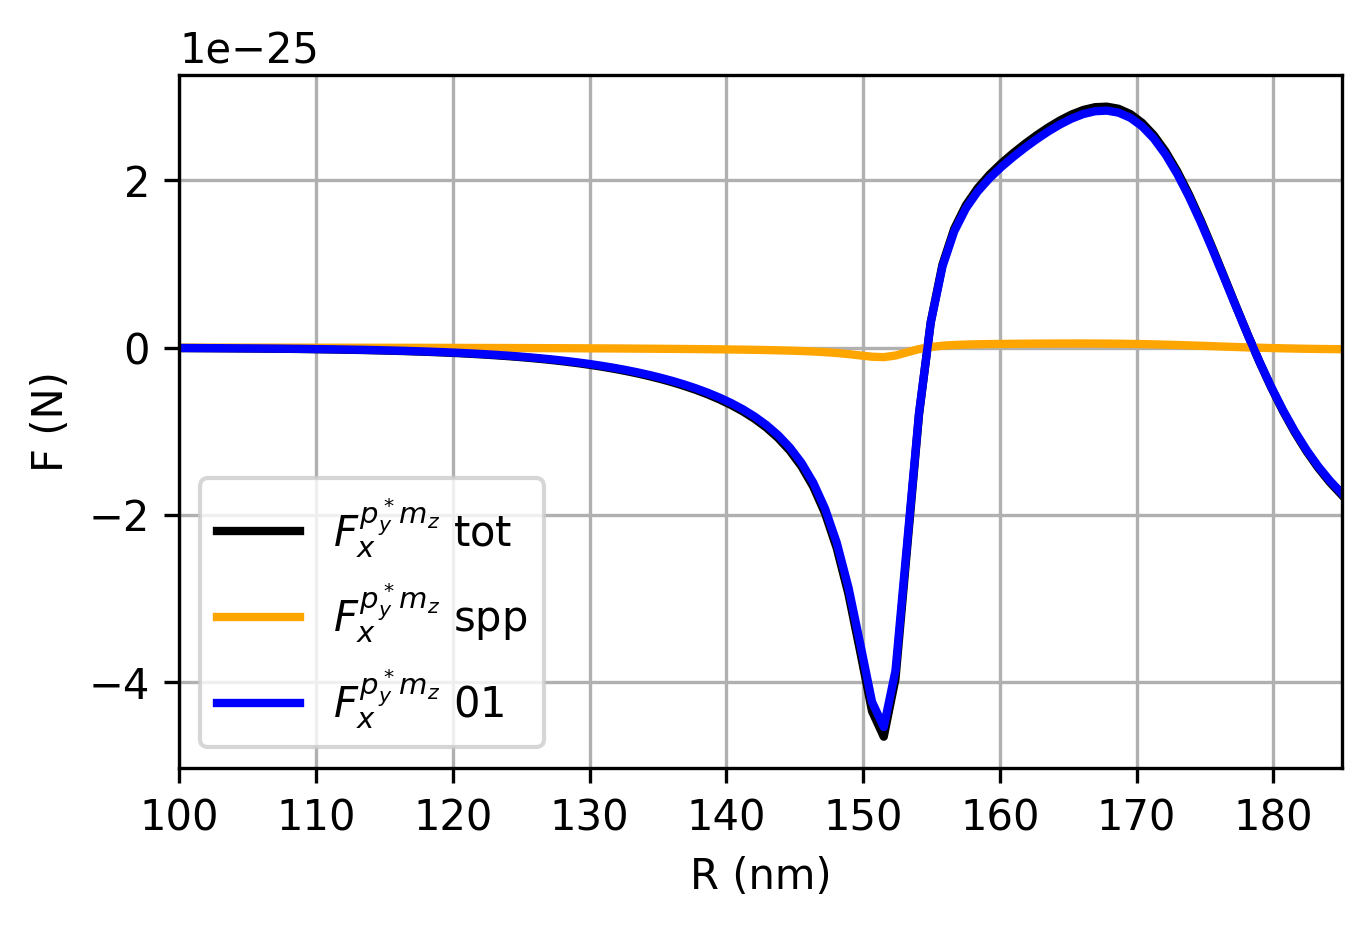

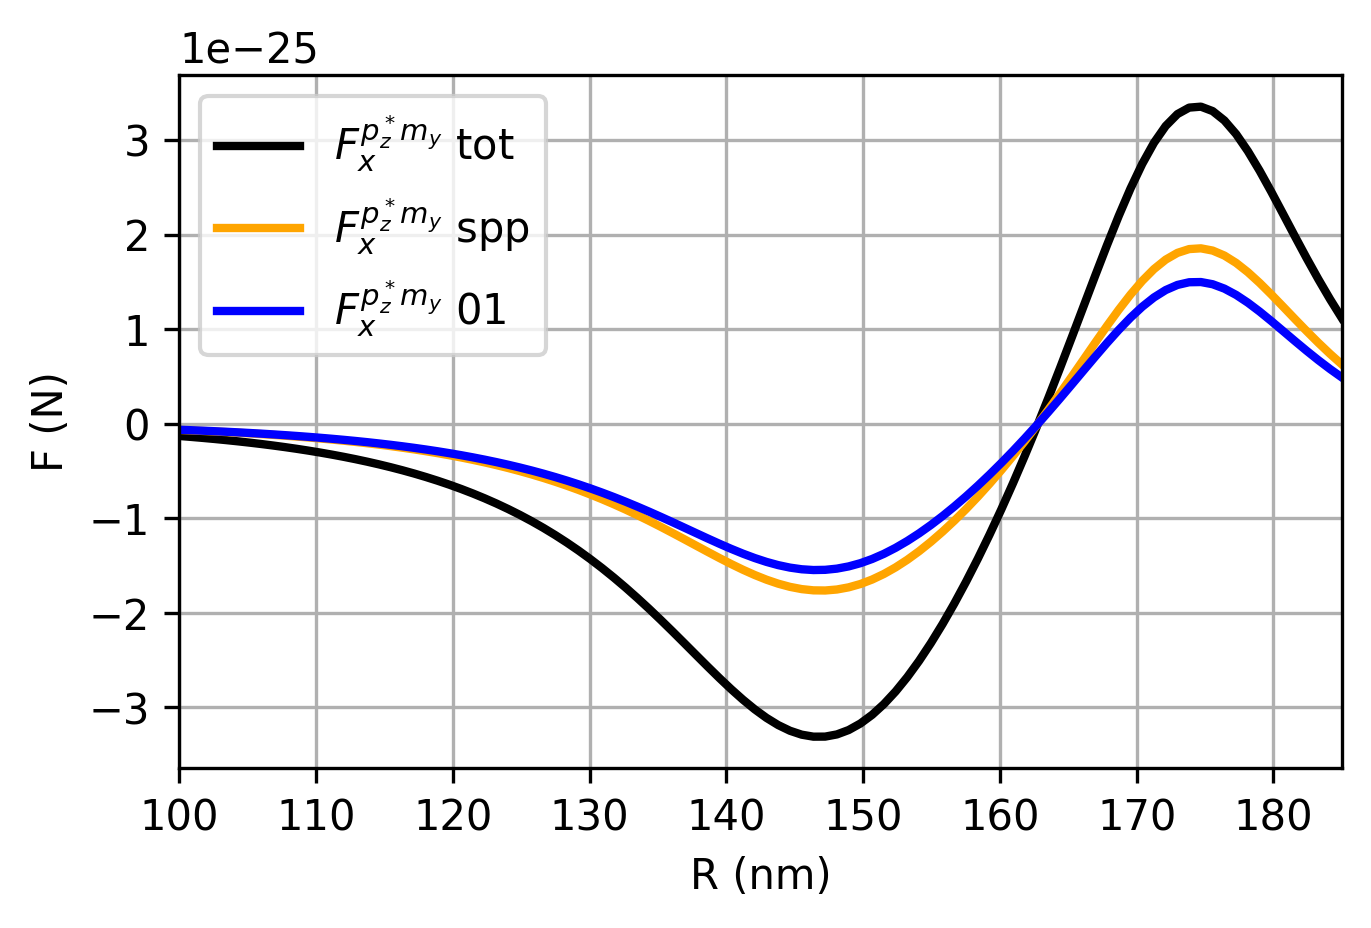

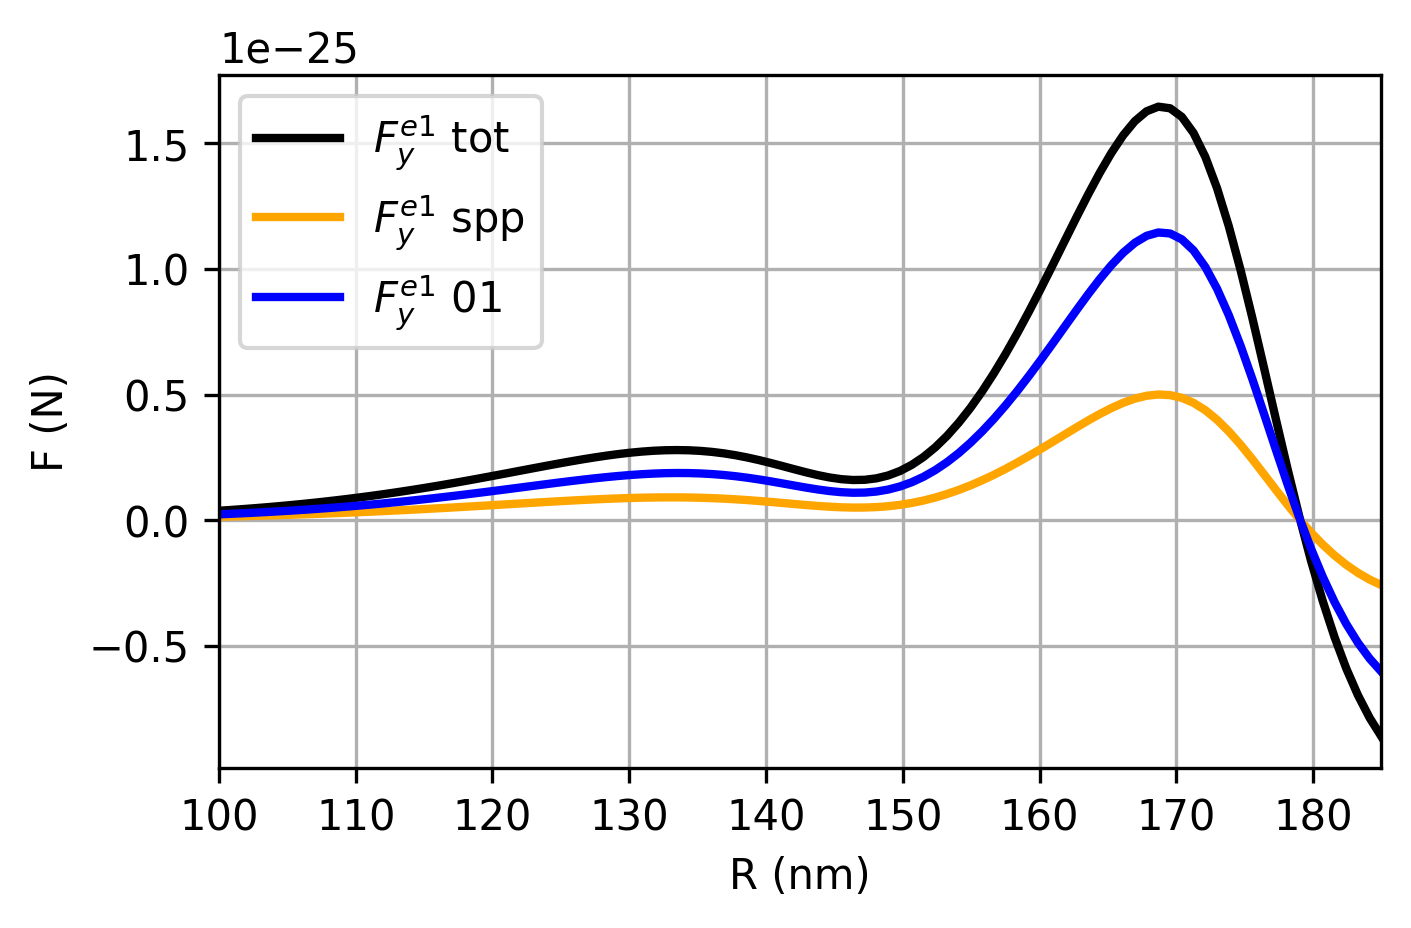

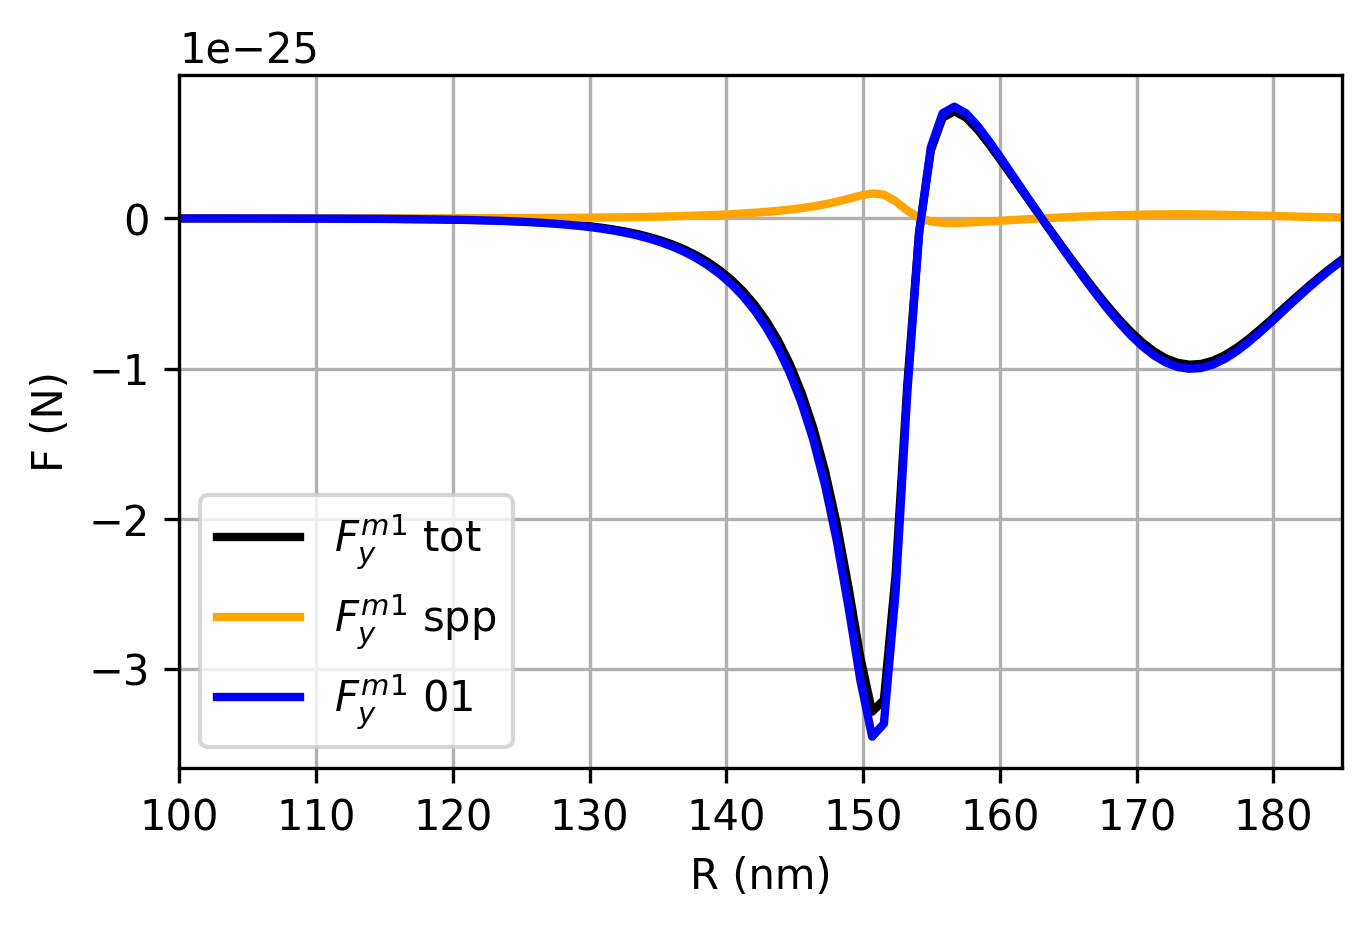

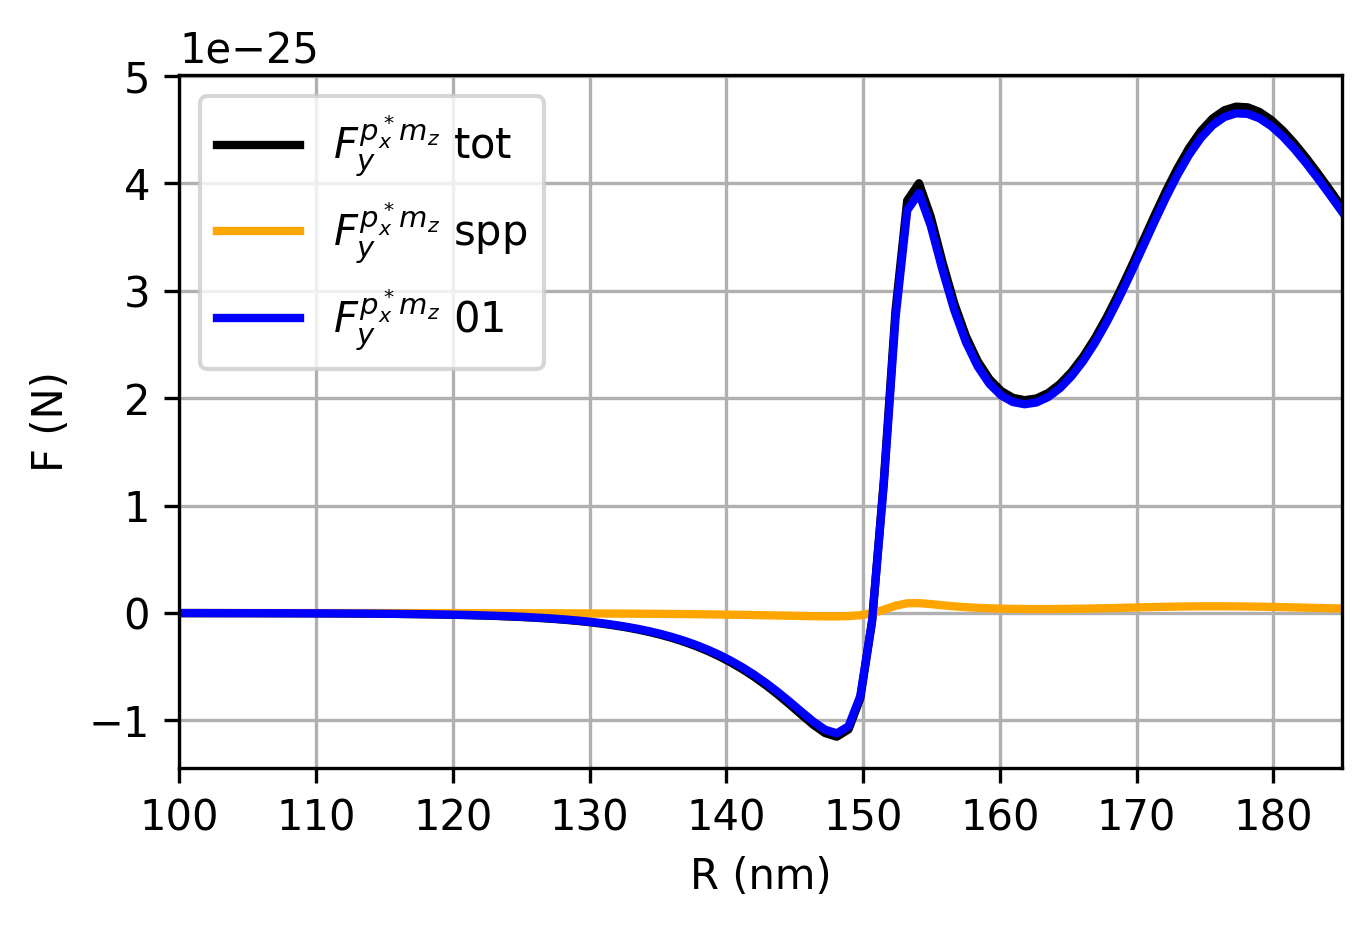

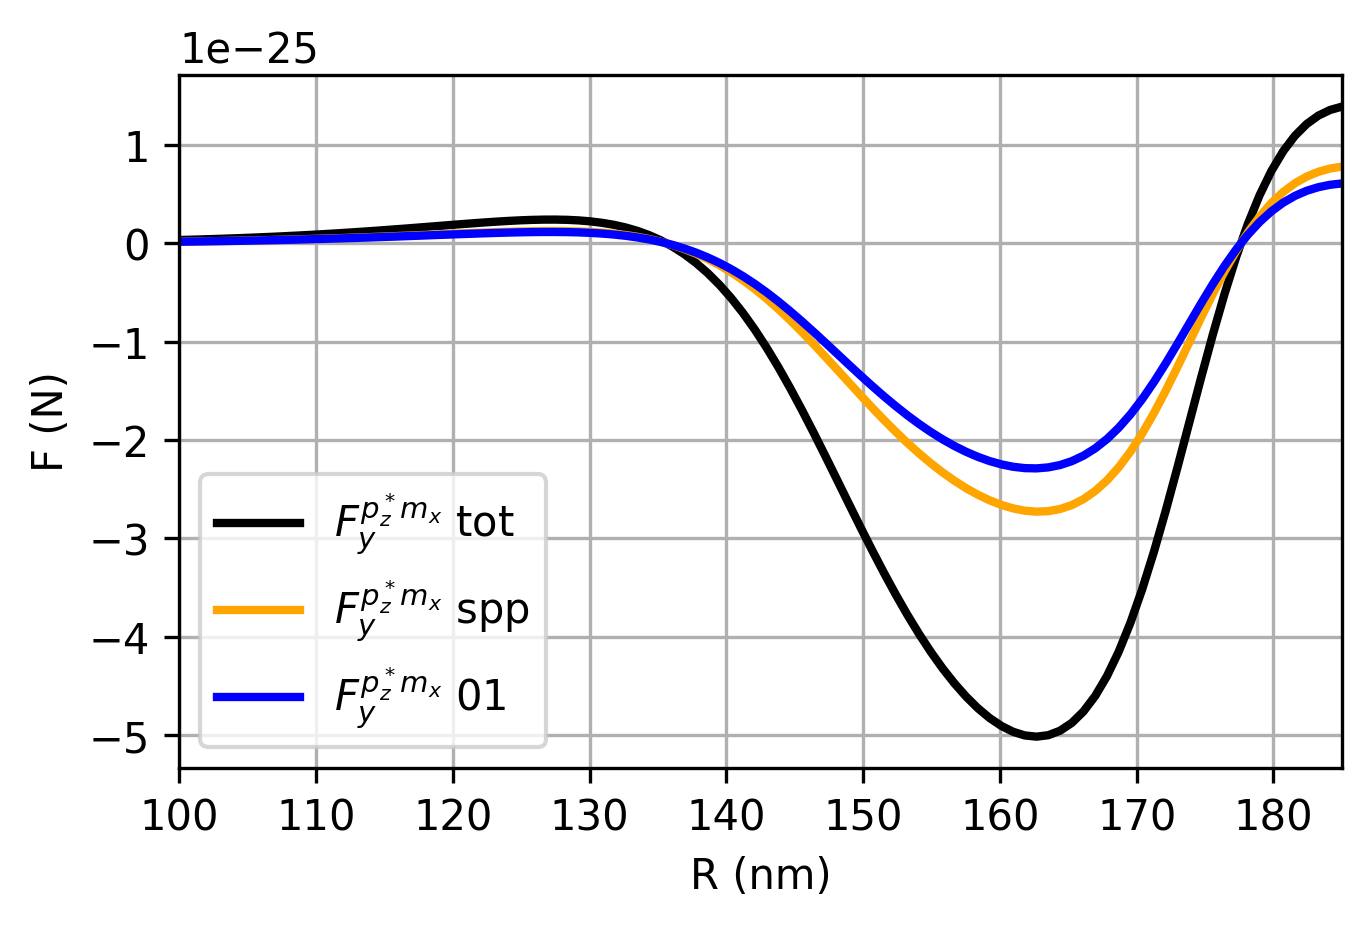

In [182]:
Ffull = [Fxe1_one, Fxm1_one, Fxpymz_one, Fxpzmy_one, Fye1_one, Fym1_one, Fypxmz_one, Fypzmx_one]
F01 = [Fxe1_01_one, Fxm1_01_one, Fxpymz_01_one, Fxpzmy_01_one, Fye1_01_one, Fym1_01_one, Fypxmz_01_one, Fypzmx_01_one]
Fspp = [Fxe1_spp_one, Fxm1_spp_one, Fxpymz_spp_one, Fxpzmy_spp_one, Fye1_spp_one, Fym1_spp_one, Fypxmz_spp_one, Fypzmx_spp_one]
Flabels =  ['$F_x^{e1}$', '$F_x^{m1}$', '$F_x^{p_y^*m_z}$', '$F_x^{p_z^*m_y}$', 
            '$F_y^{e1}$', '$F_y^{m1}$', '$F_y^{p_x^*m_z}$', '$F_y^{p_z^*m_x}$']

for i in range(len(Ffull)):
    plt.figure(figsize=(5,3), dpi=300)
    plt.plot(R, Ffull[i], label=Flabels[i]+' tot', lw=2, c='black')
    plt.plot(R, Fspp[i], label=Flabels[i]+' spp', lw=2, c='orange')
    plt.plot(R, F01[i], label=Flabels[i]+' 01', lw=2, c='blue')
    plt.xlabel('R (nm)')
    plt.xlim(R[0], R[-1])
    plt.grid()
    plt.legend()
    plt.ylabel('F (N)')
    plt.show()
    
    

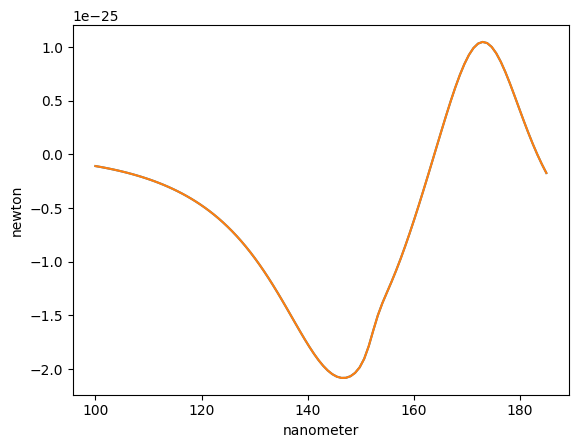

In [183]:
plt.plot(R, Fxspp_one)
plt.plot(R, Fxe1_spp_one+Fxm1_spp_one + Fxpymz_spp_one + Fxpzmy_spp_one)

Text(0.5, 0, 'R (nm)')

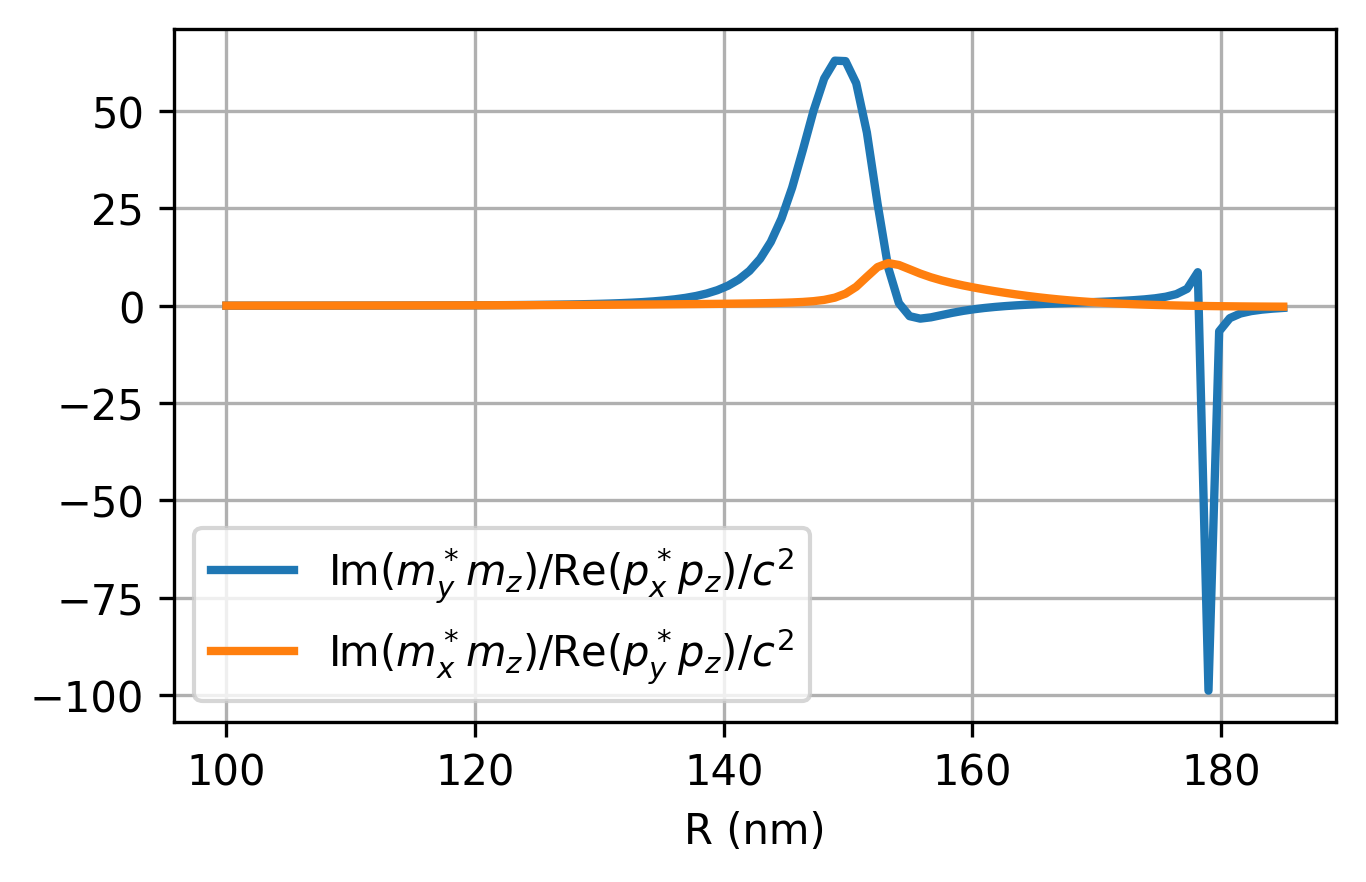

In [192]:
plt.figure(figsize=(5,3), dpi=300)
plt.plot(R, np.imag(my_one.conj()*mz_one)/np.real(px_one.conj()*pz_one*c_const**2), label='Im($m_y^* m_z$)/Re($p_x^*p_z$)/$c^2$', lw=2)

plt.plot(R, np.imag(mx_one.conj()*mz_one)/np.real(py_one.conj()*pz_one*c_const**2), label='Im($m_x^* m_z$)/Re($p_y^*p_z$)/$c^2$', lw=2)

plt.grid()
plt.legend()
plt.xlabel('R (nm)')
